## Initialization

In [1]:
import generate_masterdf as gm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import sem
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from generate_plots import subject_wise_error_plot, distribution_plots

pd.set_option("display.max.columns", None)
pd.set_option("display.precision", 4)

msize = 10
axes_fontsize = 14
title_fontsize = 18

Loading existing dataframe! If this is not desired, delete the current mater_df.csv


## Summarizing data features

In [2]:
# Loading the data as a dataframe
df_orig = gm.master_df

# error vectors and magnitudes
df_orig['ierrX'] = df_orig['isaccX'] - df_orig['TarX']
df_orig['ierrY'] = df_orig['isaccY'] - df_orig['TarY']
df_orig['ferrX'] = df_orig['fsaccX'] - df_orig['TarX']
df_orig['ferrY'] = df_orig['fsaccY'] - df_orig['TarY']
df_orig['ierr'] = np.sqrt(df_orig['ierrX']**2+df_orig['ierrY']**2)
df_orig['ferr'] = np.sqrt(df_orig['ferrX']**2+df_orig['ferrY']**2)

# Saccade gain and Percentage error in amplitude
df_orig['igain'] = (np.sqrt(df_orig['isaccX']**2+df_orig['isaccY']**2))/(np.sqrt(df_orig['TarX']**2+df_orig['TarY']**2))
df_orig['fgain'] = (np.sqrt(df_orig['fsaccX']**2+df_orig['fsaccY']**2))/(np.sqrt(df_orig['TarX']**2+df_orig['TarY']**2))
df_orig['eccentricity'] = np.sqrt(df_orig['TarX']**2+df_orig['TarY']**2)
df_orig['polang'] = np.arctan2(df_orig['TarY'], df_orig['TarX'])
df_orig['ipea'] = (df_orig['ierr'] - df_orig['eccentricity'])/df_orig['eccentricity'] # percentage error in amplitude (Muri et al. 1996)
df_orig['fpea'] = (df_orig['ferr'] - df_orig['eccentricity'])/df_orig['eccentricity'] # percentage error in amplitude (Muri et al. 1996)

# Angular error
df_orig['iang'] = np.arctan2(df_orig['isaccY'], df_orig['isaccX']) - np.arctan2(df_orig['TarY'], df_orig['TarX'])
df_orig['iang'] = np.arctan2(np.sin(df_orig['iang']), np.cos(df_orig['iang']))
df_orig['iang'] = np.rad2deg(df_orig['iang'])
df_orig['fang'] = np.arctan2(df_orig['fsaccY'], df_orig['fsaccX']) - np.arctan2(df_orig['TarY'], df_orig['TarX'])
df_orig['fang'] = np.arctan2(np.sin(df_orig['fang']), np.cos(df_orig['fang']))
df_orig['fang'] = np.rad2deg(df_orig['fang'])

# Radial and tangential errors
itheta = np.arctan2(df_orig['ierrY'], df_orig['ierrX']) - df_orig['polang']
itheta = np.arctan2(np.sin(itheta), np.cos(itheta))
df_orig['itheta'] = np.rad2deg(itheta)
df_orig['iradial'] = df_orig['ierr'] * np.cos(itheta)
df_orig['itangential'] = df_orig['ierr'] * np.sin(itheta)

ftheta = np.arctan2(df_orig['ferrY'], df_orig['ferrX']) - df_orig['polang']
ftheta = np.arctan2(np.sin(ftheta), np.cos(ftheta))
df_orig['ftheta'] = np.rad2deg(ftheta)
df_orig['fradial'] = df_orig['ferr'] * np.cos(ftheta)
df_orig['ftangential'] = df_orig['ferr'] * np.sin(ftheta)

In [3]:
df = df_orig.copy()

# Replace more than one race to white
df.loc[df['race'] == 'More than one', 'race'] = 'White'
conds = [
    df['day'].isin([1, 2, 3]),  
    df['day'] == 4,             
    df['day'] == 5              
]
choices = ['early', 'middle', 'early_dangit']
df['TMS_time'] = np.select(conds, choices, default='unknown')


# Removing trials that had timing issues
buffer = 0.25  # 2.5% buffer
conditions = (
    (df['initdur'].between(1 * (1 - buffer), 1 * (1 + buffer))) &
    (df['sampledur'].between(0.5 * (1 - buffer), 0.5 * (1 + buffer))) &
    (df['respdur'].between(0.85 * (1 - buffer), 0.85 * (1 + buffer))) &
    (df['feedbackdur'].between(0.8 * (1 - buffer), 0.8 * (1 + buffer))) &
    (
        ((df['day'].isin([1, 2, 3, 5])) & 
         (df['delay1dur'].between(2 * (1 - buffer), 2 * (1 + buffer))) & 
         (df['delay2dur'].between(2 * (1 - buffer), 2 * (1 + buffer)))) |
        ((df['day'] == 4) & 
         (df['delay1dur'].between(-1e-2, 1e-2)) & 
         (df['delay2dur'].between(4 * (1 - buffer), 4 * (1 + buffer))))
    )
)

original_shape = df.shape
df = df[conditions].dropna()

# Also remove trials with reaction times that are too small or too big
df = df[(df['isacc_rt'] > 0.15) & (df['isacc_rt'] < 1.0) & (df['fsacc_rt'] < 1.0) & (df['ierr'] <= 6)]
gstats_initial = df.groupby('subjID')['ierr'].agg(['mean', 'std'])
gstats_final = df.groupby('subjID')['ferr'].agg(['mean', 'std'])
gstats_initial['ierr_threshold'] = gstats_initial['mean'] + 3 * gstats_initial['std']
gstats_final['ferr_threshold'] = gstats_initial['mean'] + 3 * gstats_initial['std']

df = df.merge(gstats_initial['ierr_threshold'], left_on='subjID', right_index=True)
df = df.merge(gstats_final['ferr_threshold'], left_on='subjID', right_index=True)
df = df[(df['ierr'] <= df['ierr_threshold']) & (df['ferr'] <= df['ferr_threshold'])]

# Removing columns that will not be needed from here on:
df = df.drop(columns = ['bad_drift_correct', 'bad_calibration', 'breakfix',
       'no_prim_sacc', 'small_sacc', 'large_error', 'rejtrials', 'initdur', 'sampledur',
       'delay1dur', 'delay2dur', 'respdur', 'feedbackdur', 'isacc_err', 'fsacc_err'])
filtered_shape = df.shape
print(f'Trials removed = {original_shape[0] - filtered_shape[0]} = {round((original_shape[0] - filtered_shape[0])*100/original_shape[0], 2)}% ')

Trials removed = 4126 = 12.55% 


In [4]:
print('Dataframe description')
df.info()

Dataframe description
<class 'pandas.core.frame.DataFrame'>
Int64Index: 28754 entries, 0 to 32879
Data columns (total 52 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   subjID          28754 non-null  int64  
 1   day             28754 non-null  int64  
 2   gender          28754 non-null  object 
 3   race            28754 non-null  object 
 4   handedness      28754 non-null  object 
 5   hemistimulated  28754 non-null  object 
 6   age             28754 non-null  int64  
 7   weight          28754 non-null  int64  
 8   eegsize         28754 non-null  float64
 9   rnum            28754 non-null  int64  
 10  tnum            28754 non-null  int64  
 11  istms           28754 non-null  int64  
 12  ispro           28754 non-null  int64  
 13  instimVF        28754 non-null  int64  
 14  TarX            28754 non-null  float64
 15  TarY            28754 non-null  float64
 16  isaccX          28754 non-null  float64
 17  isaccY   

In [5]:
df.describe(include=object)

,gender,race,handedness,hemistimulated,trial_type,TMS_condition,TMS_time
count,28754,28754,28754,28754,28754,28754,28754
unique,2,2,2,2,4,3,3
top,M,Asian,Right,Left,pro_outVF,TMS outVF,early
freq,17360,21623,25741,15275,8965,10707,21859


## Visualization

In [6]:
small_df = df.sample(frac=0.1, random_state=42)

#numer_cols = small_df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = small_df.select_dtypes(include=['object']).columns
numer_cols = ['age', 'weight', 'TarX', 'TarY', 'isaccX', 'isaccY', 'fsaccX',
       'fsaccY', 'nsacc', 'isacc_rt', 'fsacc_rt', 'isacc_peakvel',
       'fsacc_peakvel', 'ierrX', 'ierrY', 'ferrX',
       'ferrY', 'ierr', 'ferr', 'igain', 'fgain', 'eccentricity', 'polang',
       'ipea', 'fpea', 'iang', 'fang', 'itheta', 'iradial', 'itangential',
       'ftheta', 'fradial', 'ftangential', 'ierr_threshold', 'ferr_threshold']

### Visualize numerical columns

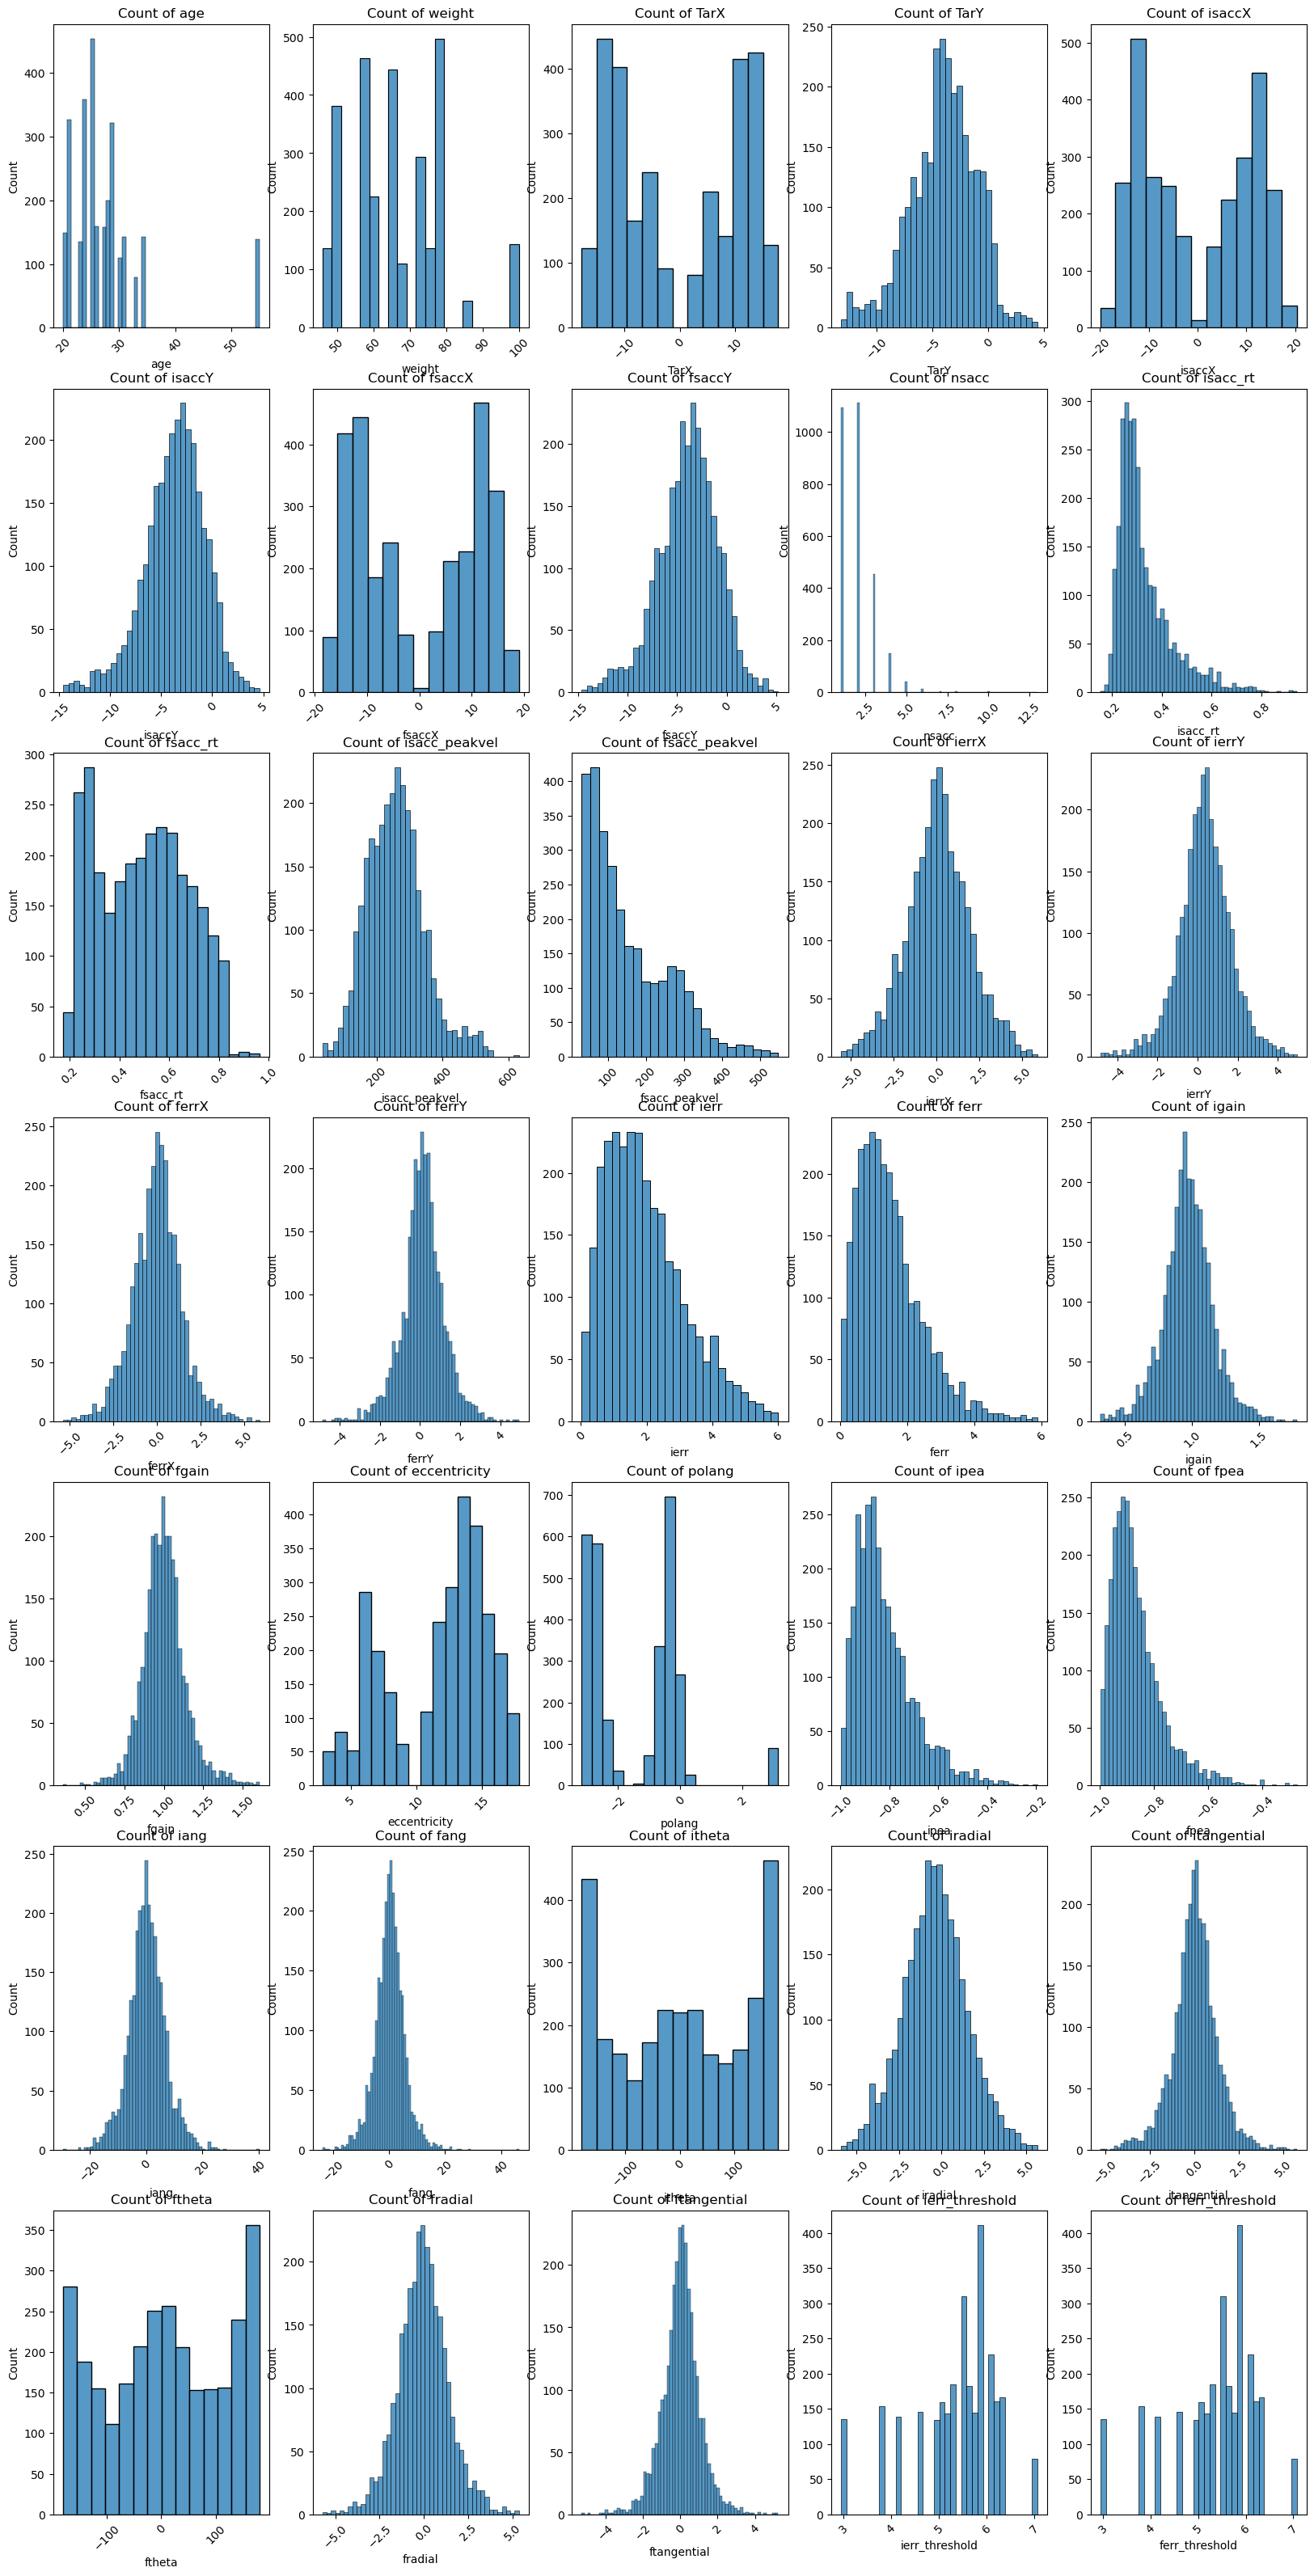

In [7]:
plt.figure(figsize=(20, 40))
for i, col in enumerate(numer_cols):
    plt.subplot(7, 5, i + 1)
    sns.histplot(x=col, data=small_df)
    plt.title(f'Count of {col}')
    plt.xticks(rotation=45)
#plt.tight_layout()
plt.show()

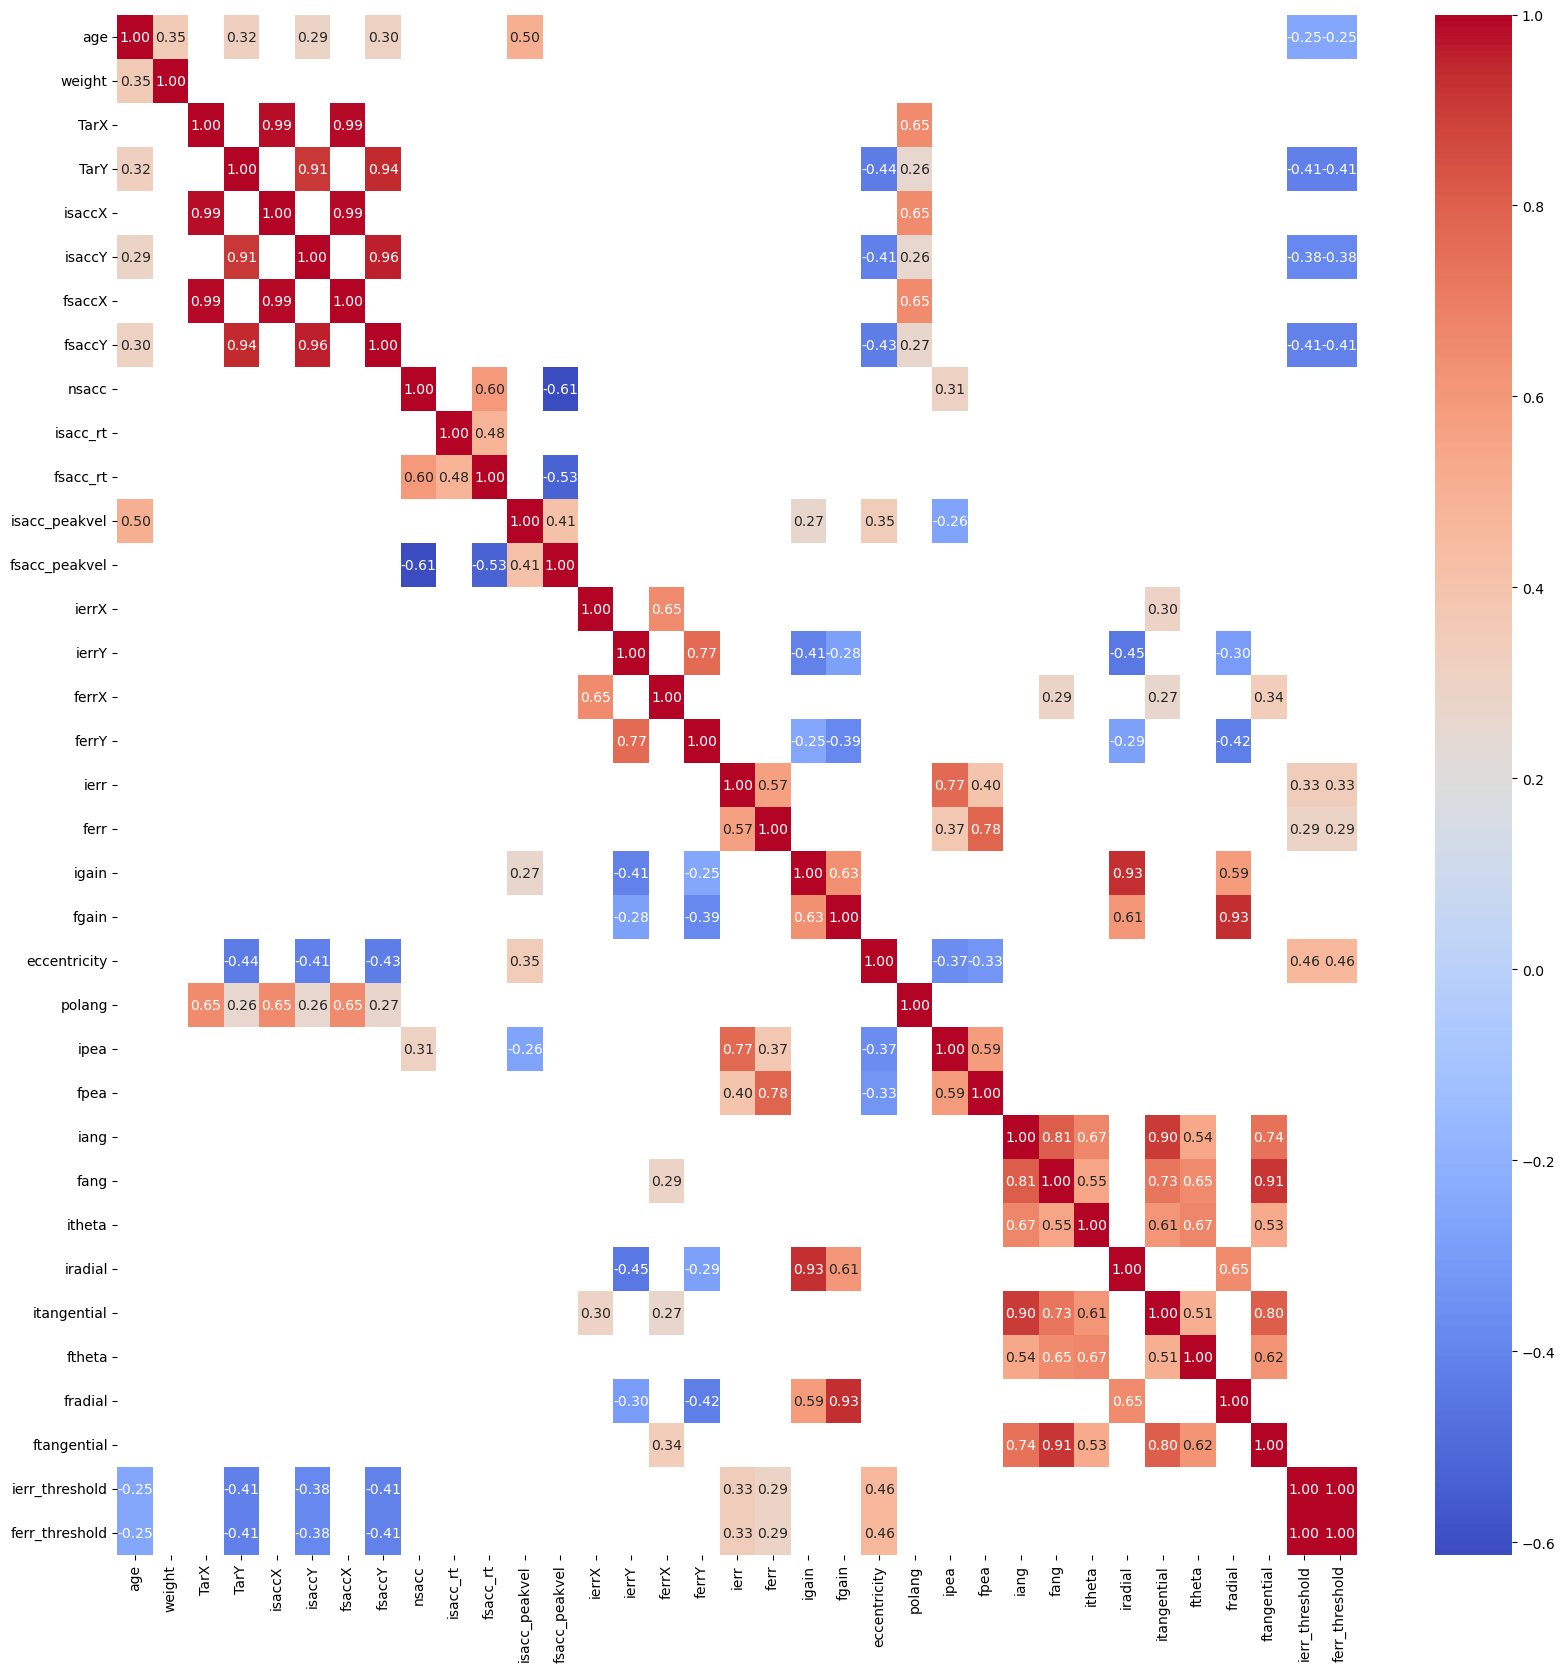

In [8]:
# Check for correlation in data
plt.figure(figsize=(20, 20))
corr_matrix = df[numer_cols].corr()
mask = (corr_matrix > 0.25) | (corr_matrix < -0.25)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', mask = ~mask,
            xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)
plt.show()

### Visualize categorical columns

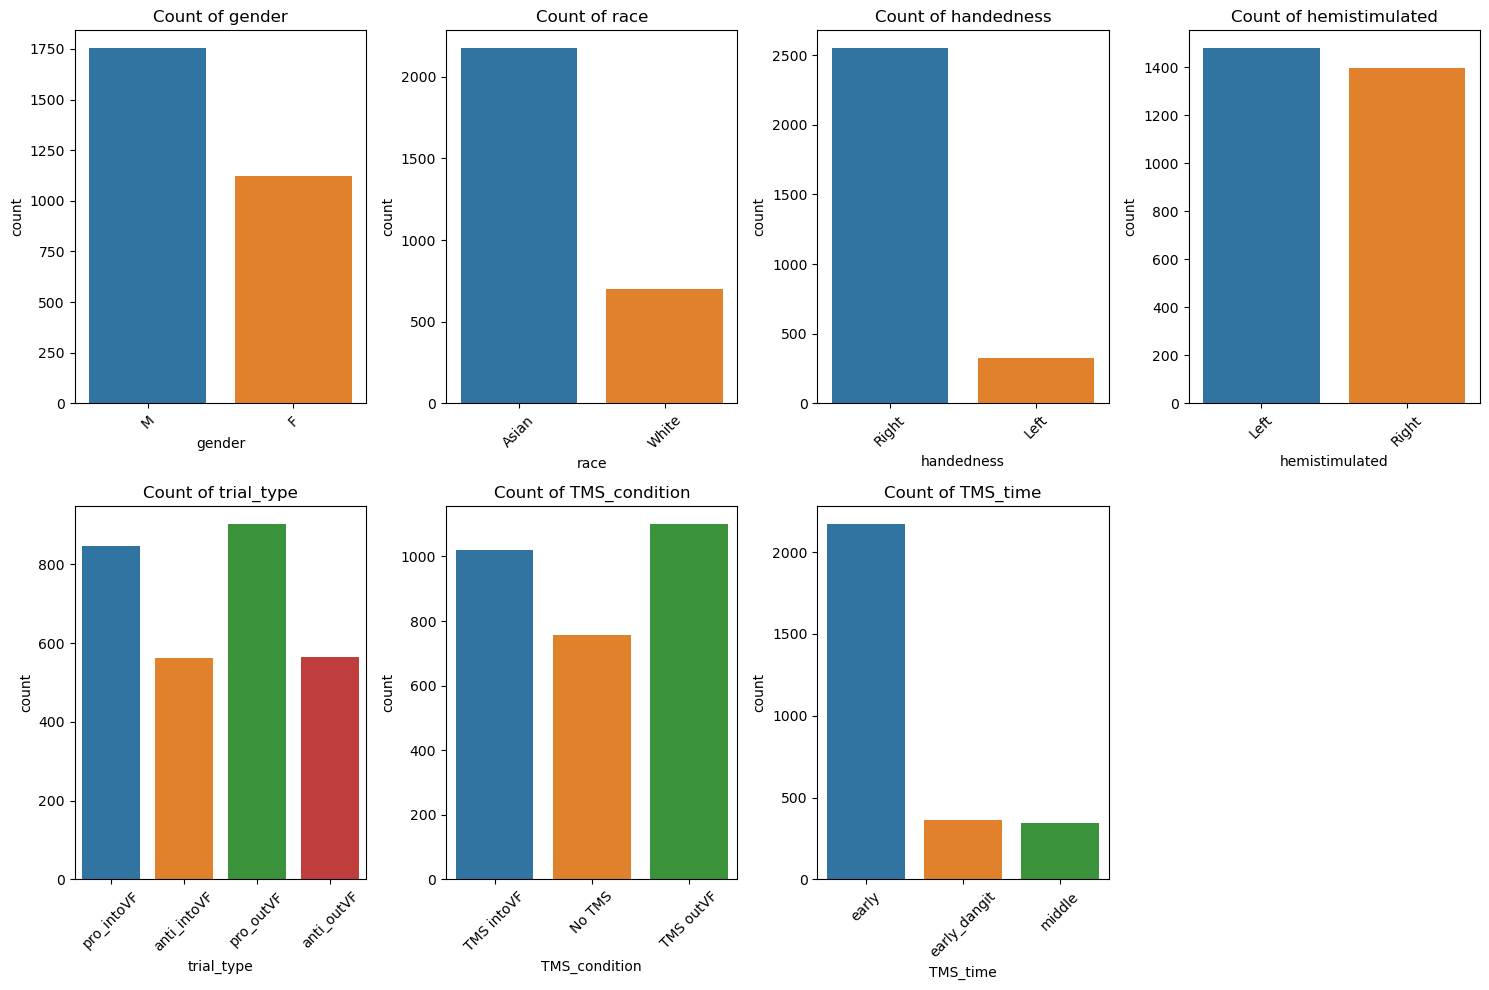

In [9]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(cat_cols):
    plt.subplot(2, 4, i + 1)
    sns.countplot(x=col, data=small_df)
    plt.title(f'Count of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Exploratory Data Analysis

In [10]:
# Dependent variables
dependent_vars = ['isacc_peakvel', 'fsacc_peakvel', 'isacc_rt', 'fsacc_rt', 
                  'ierrX', 'ierrY', 'ferrX', 'ferrY', 'igain', 'fgain', 
                  'ipea', 'fpea', 'iang', 'fang', 'itheta', 'itangential', 
                  'ftheta', 'ftangential', 'ierr_threshold', 'ferr_threshold']

agg_funcs = ['mean', 'median', 'var']
agg_df = df.groupby('subjID')[dependent_vars].agg(agg_funcs)


absolute_vars = ['ierrX', 'ierrY', 'ferrX', 'ferrY', 'iang', 'fang', 'itheta', 'itangential', 'ftheta', 'ftangential']
agg_df_abs = df[absolute_vars].abs().groupby(df['subjID']).agg(agg_funcs)

# Independent variables
independent_categorical_vars = ['gender', 'handedness', 'hemistimulated', 'trial_type', 'TMS_condition', 
                                'TMS_time']
encoded_vars = pd.get_dummies(df[independent_categorical_vars], drop_first=True)
independent_df = pd.concat([df[['subjID', 'age', 'weight', 'polang', 'eccentricity']], encoded_vars], axis=1)
independent_df = independent_df.groupby('subjID').first() 

final_df = independent_df.join(agg_df)
final_df_abs = independent_df.join(agg_df_abs)

/var/folders/0w/p5w49zc93976_p2hxj1zws2w0000gn/T/ipykernel_56731/499834835.py:21: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  final_df = independent_df.join(agg_df)
/var/folders/0w/p5w49zc93976_p2hxj1zws2w0000gn/T/ipykernel_56731/499834835.py:22: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  final_df_abs = independent_df.join(agg_df_abs)


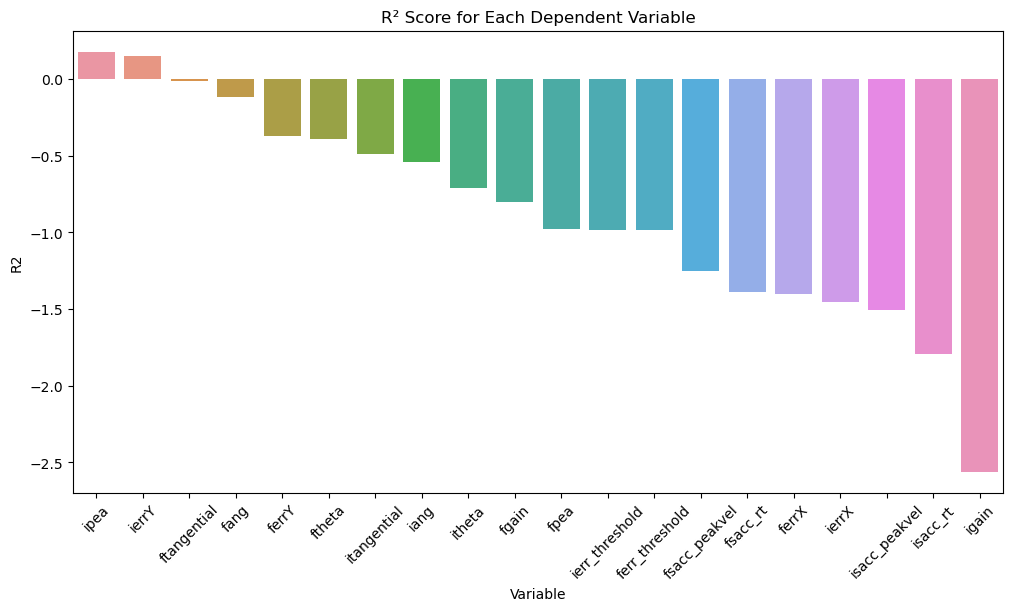

In [12]:
X = independent_df

R2_df = pd.DataFrame(columns=['Variable', 'R2'])

for col in agg_df.columns.levels[0]:
    y = agg_df[(col, 'mean')]  
    scores = cross_val_score(RandomForestRegressor(random_state=42), X, y, cv=5, scoring='r2')
    
    avg_score = np.mean(scores)
    new_row = pd.DataFrame({'Variable': [col], 'R2': [avg_score]})
    R2_df = pd.concat([R2_df, new_row], ignore_index=True)


R2_df.sort_values(by='R2', ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(x='Variable', y='R2', data=R2_df)
plt.xticks(rotation=45)
plt.title('R² Score for Each Dependent Variable')
plt.show()

In [13]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = smf.mixedlm("isacc_peakvel ~ age + weight", df, groups=df["subjID"])
result = model.fit()

print(result.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: isacc_peakvel
No. Observations: 28754   Method:             REML         
No. Groups:       21      Scale:              2751.7018    
Min. group size:  500     Log-Likelihood:     -154735.9720 
Max. group size:  1671    Converged:          Yes          
Mean group size:  1369.2                                   
-----------------------------------------------------------
               Coef.   Std.Err.   z    P>|z| [0.025  0.975]
-----------------------------------------------------------
Intercept      178.762   71.301  2.507 0.012 39.015 318.508
age              6.660    1.903  3.499 0.000  2.930  10.391
weight          -1.643    1.022 -1.608 0.108 -3.647   0.360
Group Var     3417.791   21.644                            



In [ ]:
# Summary across conditions for subjects
table_summary = pd.pivot_table(df, values = 'ierr', index = ['subjID'], columns = ['TMS_condition', 'ispro'], aggfunc = lambda x: np.round(np.sum(~pd.isnull(x))/2, 2))
table_summary

In [ ]:
def calculate_mean_and_se(group, error_metric):
    #temp_stuff = group[error_metric]
    mean = group[error_metric].mean()
    se = group[error_metric].sem()
    return pd.Series({'mean': mean, 'se': se})

def plot_error_metric(df, error_metric):
    # df = df[df['ierr'] < 6.4]
    # df = df[(df['subjID'] != 11)]
    # #df = df[(df['subjID'] != 11) & (df['subjID'] !=8)]
    #df = df[df['subjID'] != 11]
    subject_counts = df.groupby('subjID')['day'].nunique()
    valid_subjects = subject_counts[subject_counts == 5].index
    df_filtered = df[df['subjID'].isin(valid_subjects)  & (df['ispro'] == 1)]
    conditions = {
        'No TMS': df_filtered[(df_filtered['TMS_condition'] == 'No TMS') & (df_filtered['day'].isin([1, 2, 3]))],
        'early inVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS intoVF') & (df_filtered['day'] == 4)],
        'early outVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS outVF') & (df_filtered['day'] == 4)],
        'mid inVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS intoVF') & (df_filtered['day'].isin([1, 2, 3]))],
        'mid outVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS outVF') & (df_filtered['day'].isin([1, 2, 3]))],
        'late inVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS intoVF') & (df_filtered['day'] == 5)],
        'late outVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS outVF') & (df_filtered['day'] == 5)],
    }

    # conditions = {
    #     'NoTMS inVF': df_filtered[(df_filtered['TMS_condition'] == 'No TMS') & (df_filtered['day'].isin([1, 2, 3])) & (df_filtered['instimVF'] == 1)],
    #     'NoTMS outVF': df_filtered[(df_filtered['TMS_condition'] == 'No TMS') & (df_filtered['day'].isin([1, 2, 3])) & (df_filtered['instimVF'] == 0)],
    #     'early inVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS intoVF') & (df_filtered['day'] == 4)],
    #     'early outVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS outVF') & (df_filtered['day'] == 4)],
    #     'mid inVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS intoVF') & (df_filtered['day'].isin([1, 2, 3]))],
    #     'mid outVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS outVF') & (df_filtered['day'].isin([1, 2, 3]))],
    #     'late inVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS intoVF') & (df_filtered['day'] == 5)],
    #     'late outVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS outVF') & (df_filtered['day'] == 5)],
    # }
    results = {cond: data.groupby('subjID').apply(calculate_mean_and_se, error_metric=error_metric) for cond, data in conditions.items()}
    combined_results = pd.concat(results, names=['Condition']).reset_index()
    print(np.mean(combined_results[combined_results['Condition']=='No TMS']['mean']))
    #combined_results.to_csv('cc_test.csv', index = False)

    plt.figure(figsize=(10, 6))
    sns.pointplot(data=combined_results, x='Condition', y='mean', linestyle="none", capsize=.2, errorbar="se")
    sns.stripplot(data=combined_results, x='Condition', y='mean', color="black", jitter=False, size=6)
    # sns.lineplot(data=combined_results, x='Condition', y='mean', hue='subjID', 
    #                 palette=['gray']*len(valid_subjects), legend=False, dashes=True, linewidth=1)
    plt.title(f'Mean {error_metric} with Standard Error (N = {len(valid_subjects)} subjects)')
    plt.ylabel(f'Mean {error_metric}')
    plt.xlabel('Condition')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
plot_error_metric(df, 'ierr')
#plot_error_metric(df, 'ferr')
# plot_error_metric(df, 'igain')
# plot_error_metric(df, 'iamp')
# plot_error_metric(df, 'idir')
#plot_error_metric(df, 'fsacc_rt')

In [ ]:
def compute_stats(df, error_metric, aspect):
    # df = df[df['ierr'] < 6.4]
    # df = df[(df['subjID'] != 11)]
    #df = df[(df['subjID'] != 11) & (df['subjID'] !=8)]
    #df = df[df['subjID'] != 11]
    subject_counts = df.groupby('subjID')['day'].nunique()
    valid_subjects = subject_counts[subject_counts == 5].index
    df_filtered = df[df['subjID'].isin(valid_subjects)  & (df['ispro'] == 1)]

    conditions = {
        'NoTMS': df_filtered[(df_filtered['TMS_condition'] == 'No TMS') & (df_filtered['day'].isin([1, 2, 3]))],
        'early inVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS intoVF') & (df_filtered['day'] == 4)],
        'early outVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS outVF') & (df_filtered['day'] == 4)],
        'mid inVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS intoVF') & (df_filtered['day'].isin([1, 2, 3]))],
        'mid outVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS outVF') & (df_filtered['day'].isin([1, 2, 3]))],
        'late inVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS intoVF') & (df_filtered['day'] == 5)],
        'late outVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS outVF') & (df_filtered['day'] == 5)],
    }

    results = {cond: data.groupby('subjID').apply(calculate_mean_and_se, error_metric=error_metric) for cond, data in conditions.items()}
    combined_results = pd.concat(results, names=['Condition']).reset_index()

    # aovrm = AnovaRM(combined_results, depvar=aspect, subject='subjID', within=['Condition'])
    # res = aovrm.fit()
    # print(res.summary())
    friedman_data = [group[aspect].values for _, group in combined_results.groupby('Condition')]
    friedman_stat, friedman_p = stats.friedmanchisquare(*friedman_data)
    
    print(f'Friedman Test Statistic: {friedman_stat}, P-value: {friedman_p}')

    if friedman_p < 0.1:
    #if res.anova_table['Pr > F'][0] < 0.05:
        comparison_pairs = [
            ('NoTMS', 'early inVF'),
            ('NoTMS', 'mid inVF'),
            ('NoTMS', 'late inVF'),
            ('early inVF', 'early outVF'),
            ('mid inVF', 'mid outVF'),
            ('late inVF', 'late outVF')
        ]
        alpha_adjusted = 0.05 / (len(comparison_pairs))  # +1 for ANOVA
        print(f'Corrected alphsa value after Bonferroni correction for {len(comparison_pairs) + 1} tests = {round(alpha_adjusted, 4)}')

        results = []

        for pair in comparison_pairs:
            condition1, condition2 = pair
            data1 = combined_results[combined_results['Condition'] == condition1][aspect]
            data2 = combined_results[combined_results['Condition'] == condition2][aspect]
            stat, pval = stats.wilcoxon(data1, data2)
            reject = pval < alpha_adjusted
            results.append([condition1, condition2, stat, pval, reject])

        results_df = pd.DataFrame(results, columns=['Condition 1', 'Condition 2', 'WRS_stat', 'p-value', 'Reject Null'])
        print(results_df)
          
compute_stats(df, 'ierr', 'mean')

In [ ]:
def calculate_mean_and_se(group, error_metric):
    mean = group[error_metric].mean()
    se = group[error_metric].sem()
    return pd.Series({'mean': mean, 'se': se})

def plot_error_metric(df, error_metric):
    #df = df[(df['subjID'] != 11) & (df['subjID'] !=8)]
    df = df[df['ierr'] < 6.4]
    df = df[(df['subjID'] != 11)]
    subject_counts = df.groupby('subjID')['day'].nunique()
    valid_subjects = subject_counts[subject_counts == 5].index
    df_filtered = df[df['subjID'].isin(valid_subjects)  & (df['ispro'] == 1)]
    conditions = {
        'No TMS': df_filtered[(df_filtered['TMS_condition'] == 'No TMS') & (df_filtered['day'].isin([1, 2, 3]))],
        'early inVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS intoVF') & (df_filtered['day'] == 4)],
        'early outVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS outVF') & (df_filtered['day'] == 4)],
        'mid inVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS intoVF') & (df_filtered['day'].isin([1, 2, 3]))],
        'mid outVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS outVF') & (df_filtered['day'].isin([1, 2, 3]))],
        'late inVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS intoVF') & (df_filtered['day'] == 5)],
        'late outVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS outVF') & (df_filtered['day'] == 5)],
    }
    
    results = {cond: data.groupby('subjID').apply(calculate_mean_and_se, error_metric=error_metric) for cond, data in conditions.items()}
    combined_results = pd.concat(results, names=['Condition']).reset_index()
    
    max_value = combined_results['mean'].max()
    min_value = combined_results['mean'].min()
    margin = (max_value - min_value) * 0.1 
    xr = [min_value - margin, max_value + margin]
    yr = xr  

    # start_tick = np.floor((min_value - margin) / 0.5) * 0.5
    # end_tick = np.ceil((max_value + margin) / 0.5) * 0.5
    # ticks = np.arange(start_tick, end_tick + 0.5, 0.5)

    time_periods = ['early', 'mid', 'late']
    colors = ['r', 'g', 'b']

    f, axs = plt.subplots(1, 3, figsize=(15, 6))

    for i, time in enumerate(time_periods):
        axs[i].scatter(combined_results[combined_results['Condition'] == 'No TMS']['mean'], 
                       combined_results[combined_results['Condition'] == f'{time} inVF']['mean'], 
                       facecolors=colors[i], edgecolors=colors[i], label='inVF')
        axs[i].scatter(combined_results[combined_results['Condition'] == 'No TMS']['mean'], 
                       combined_results[combined_results['Condition'] == f'{time} outVF']['mean'], 
                       facecolors='none', edgecolors=colors[i], label='outVF')
        axs[i].plot(xr, yr, '--', color='k')
        axs[i].set_xlim(xr)
        axs[i].set_ylim(yr)
        # axs[i].set_xticks(ticks)
        # axs[i].set_yticks(ticks)
        axs[i].set_xlabel('No TMS error (dva)')
        axs[i].set_ylabel(f'{time.capitalize()} TMS error (dva)')
        axs[i].set_title(f'{time.capitalize()} TMS Period')
        axs[i].legend()

    plt.show()
plot_error_metric(df, 'ierr')
#plot_error_metric(df, 'ferr')
# plot_error_metric(df, 'igain')
# plot_error_metric(df, 'iamp')
# plot_error_metric(df, 'idir')
#plot_error_metric(df, 'fsacc_rt')

In [ ]:
def compute_stats(df, error_metric):
    #df = df[df['subjID'] != 11]
    subject_counts = df.groupby('subjID')['day'].nunique()
    valid_subjects = subject_counts[subject_counts == 5].index
    df_filtered = df[df['subjID'].isin(valid_subjects)  & (df['ispro'] == 1)]

    conditions = {
        'NoTMS': df_filtered[(df_filtered['TMS_condition'] == 'No TMS') & (df_filtered['day'].isin([1, 2, 3]))],
        'early inVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS intoVF') & (df_filtered['day'] == 4)],
        'early outVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS outVF') & (df_filtered['day'] == 4)],
        'mid inVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS intoVF') & (df_filtered['day'].isin([1, 2, 3]))],
        'mid outVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS outVF') & (df_filtered['day'].isin([1, 2, 3]))],
        'late inVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS intoVF') & (df_filtered['day'] == 5)],
        'late outVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS outVF') & (df_filtered['day'] == 5)],
    }

    fvalue, pvalue = stats.f_oneway(*[group[error_metric] for group in conditions.values()])
    print('ANOVA results: F=', fvalue, ', p=', pvalue)

    if pvalue < 0.05:
        tukey_data = pd.concat(conditions, names=['Condition', 'Index']).reset_index(level='Condition')
        tukey = pairwise_tukeyhsd(endog=tukey_data[error_metric],
                                  groups=tukey_data['Condition'],
                                  alpha=0.05)
        print(tukey)
     
compute_stats(df, 'ierr')

In [ ]:
def compute_stats(df, error_metric):
    #df = df[df['subjID'] != 11]
    subject_counts = df.groupby('subjID')['day'].nunique()
    valid_subjects = subject_counts[subject_counts == 5].index
    df_filtered = df[df['subjID'].isin(valid_subjects)  & (df['ispro'] == 1)]

    conditions = {
        'NoTMS': df_filtered[(df_filtered['TMS_condition'] == 'No TMS') & (df_filtered['day'].isin([1, 2, 3]))],
        'early inVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS intoVF') & (df_filtered['day'] == 4)],
        'early outVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS outVF') & (df_filtered['day'] == 4)],
        'mid inVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS intoVF') & (df_filtered['day'].isin([1, 2, 3]))],
        'mid outVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS outVF') & (df_filtered['day'].isin([1, 2, 3]))],
        'late inVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS intoVF') & (df_filtered['day'] == 5)],
        'late outVF': df_filtered[(df_filtered['TMS_condition'] == 'TMS outVF') & (df_filtered['day'] == 5)],
    }
    results = {cond: data.groupby('subjID').apply(calculate_mean_and_se, error_metric=error_metric) for cond, data in conditions.items()}
    combined_results = pd.concat(results, names=['Condition']).reset_index()
    
    fvalue, pvalue = stats.f_oneway(*[group[error_metric] for group in combined_results.groupby('Condition')])
    print('ANOVA results: F=', fvalue, ', p=', pvalue)

    if pvalue < 0.05:
        comparison_pairs = [
            ('NoTMS', 'early inVF'),
            ('NoTMS', 'mid inVF'),
            ('NoTMS', 'late inVF'),
            ('early inVF', 'early outVF'),
            ('mid inVF', 'mid outVF'),
            ('late inVF', 'late outVF')
        ]
        alpha_adjusted = 0.05 / (len(comparison_pairs) + 1)  # +1 for ANOVA
        print(f'Corrected alpha value after Bonferroni correction for {len(comparison_pairs) + 1} tests = {alpha_adjusted}')

        for pair in comparison_pairs:
            condition1, condition2 = pair
            data1 = combined_results[combined_results['Condition'] == condition1][error_metric]
            data2 = combined_results[combined_results['Condition'] == condition2][error_metric]
            stat, pval = stats.ttest_rel(data1, data2)
            if pval < alpha_adjusted:
                print(f't-test for {condition1} vs {condition2}: t-stat = {stat}, p-value = {pval}, reject = True')
            else:
                print(f't-test for {condition1} vs {condition2}: t-stat = {stat}, p-value = {pval}, reject = False')
      
     
compute_stats(df, 'ierr')

In [ ]:
def calculate_mean_and_se(group, error_metric):
    mean = group[error_metric].mean()
    se = group[error_metric].sem()
    return pd.Series({'mean': mean, 'se': se})

def plot_behav_data(df, error_metric):
    df =  df[(df['subjID'] != 11) & (df['subjID'] != 18) & (df['subjID'] != 16)  ]
    subject_counts = df.groupby('subjID')['day'].nunique()
    # valid_subjects = subject_counts[subject_counts == 5].index
    # df_filtered = df[df['subjID'].isin(valid_subjects)]
    # df_pro = df_filtered[df_filtered['ispro'] == 1]
    # df_anti = df_filtered[df_filtered['ispro'] == 0]

    df_pro = df[df['ispro'] == 1]
    df_anti = df[df['ispro'] == 0]

    
    pro_conditions = {
        'NoTMS inVF': df_pro[(df_pro['TMS_condition'] == 'No TMS') & (df_pro['day'].isin([1, 2, 3])) & (df_pro['instimVF'] == 1)],
        'NoTMS outVF': df_pro[(df_pro['TMS_condition'] == 'No TMS') & (df_pro['day'].isin([1, 2, 3])) & (df_pro['instimVF'] == 0)],
        'TMS inVF': df_pro[(df_pro['TMS_condition'] == 'TMS intoVF') & (df_pro['day'].isin([1, 2, 3]))],
        'TMS outVF': df_pro[(df_pro['TMS_condition'] == 'TMS outVF') & (df_pro['day'].isin([1, 2, 3]))],
    }
    anti_conditions = {
        'NoTMS inVF': df_anti[(df_anti['TMS_condition'] == 'No TMS') & (df_anti['day'].isin([1, 2, 3])) & (df_anti['instimVF'] == 1)],
        'NoTMS outVF': df_anti[(df_anti['TMS_condition'] == 'No TMS') & (df_anti['day'].isin([1, 2, 3])) & (df_anti['instimVF'] == 0)],
        'TMS inVF': df_anti[(df_anti['TMS_condition'] == 'TMS intoVF') & (df_anti['day'].isin([1, 2, 3]))],
        'TMS outVF': df_anti[(df_anti['TMS_condition'] == 'TMS outVF') & (df_anti['day'].isin([1, 2, 3]))],
    }
    pro_results = {cond: data.groupby('subjID').apply(calculate_mean_and_se, error_metric=error_metric) for cond, data in pro_conditions.items()}
    anti_results = {cond: data.groupby('subjID').apply(calculate_mean_and_se, error_metric=error_metric) for cond, data in anti_conditions.items()}
    print(np.shape(pro_results))
    combined_pro = pd.concat(pro_results, names=['Condition'])
    combined_pro.reset_index(inplace=True)

    combined_anti = pd.concat(anti_results, names=['Condition'])
    combined_anti.reset_index(inplace=True)

    combined_pro['Type'] = 'Pro'
    combined_anti['Type'] = 'Anti'
    combined_data = pd.concat([combined_pro, combined_anti])

    plt.figure(figsize=(10, 6))
    sns.pointplot(data=combined_data, x='Condition', y='mean', hue='Type', linestyles='none', capsize=.2, errorbar="se", dodge=0.4)
    #sns.stripplot(data=combined_data, x='Condition', y='mean', hue = 'True', color="black", jitter=False, size=6)
    plt.title(f'Mean {error_metric} with Standard Error (N = {len(subject_counts)} subjects)')
    plt.ylabel(f'Mean {error_metric}')
    plt.xlabel('Condition')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
plot_behav_data(df, 'ierr')
# plot_behav_data(df, 'ferr')
# # plot_error_metric(df, 'igain')
# # plot_error_metric(df, 'iamp')
# plot_behav_data(df, 'isacc_rt')
# plot_behav_data(df, 'fsacc_rt')

In [ ]:
def compute_stats_main(df, error_metric):
    df_filtered = df.copy()

    conditions = {}
    for tms_cond in ['No TMS', 'TMS']:
        for vf_cond in ['inVF', 'outVF']:
            for is_pro in [0, 1]:  
                key = f"{'Pro' if is_pro == 1 else 'Anti'} {tms_cond} {vf_cond}"
                conditions[key] = df_filtered[
                    (df_filtered['istms'] == (1 if tms_cond == 'TMS' else 0)) &
                    (df_filtered['instimVF'] == (1 if vf_cond == 'inVF' else 0)) &
                    (df_filtered['ispro'] == is_pro)
                ]
    fvalue, pvalue = stats.f_oneway(*[group[error_metric] for group in conditions.values()])
    print('ANOVA results: F=', fvalue, ', p=', pvalue)

    if pvalue < 0.05:
        tukey_data = pd.concat(conditions, names=['Condition', 'Index']).reset_index(level='Condition')
        tukey = pairwise_tukeyhsd(endog=tukey_data[error_metric],
                                  groups=tukey_data['Condition'],
                                  alpha=0.05)
        print(tukey)

compute_stats_main(df, 'ierr')

## Visualize different metrics and their relationship with each other

In [ ]:
cols_to_plot = ['ierr', 'igain', 'iang', 'itheta', 'iradial', 'itangential', 
                    'isacc_peakvel', 'isacc_rt']
   
# df['trial_type'].replace(['pro_intoVF', 'pro_outVF', 'anti_intoVF', 'anti_outVF'],
#                          [0, 1, 2, 3], inplace=True)
# df['TMS_condition'].replace(['No TMS', 'TMS intoVF', 'TMS outVF'],
#                      [0, 1, 2], inplace=True) 
pd.plotting.scatter_matrix(df[cols_to_plot], figsize = (25, 25), alpha = 0.8)
plt.show()

In [ ]:
df['condition'] = ''
df.loc[(df['istms'] == 0) & (df['ispro'] == 1) & (df['instimVF'] == 1), 'condition'] = 'NT_pin'
df.loc[(df['istms'] == 0) & (df['ispro'] == 1) & (df['instimVF'] == 0), 'condition'] = 'NT_pout'
df.loc[(df['istms'] == 0) & (df['ispro'] == 0) & (df['instimVF'] == 1), 'condition'] = 'NT_ain'
df.loc[(df['istms'] == 0) & (df['ispro'] == 0) & (df['instimVF'] == 0), 'condition'] = 'NT_aout'
df.loc[(df['istms'] == 1) & (df['ispro'] == 1) & (df['instimVF'] == 1), 'condition'] = 'T_pin'
df.loc[(df['istms'] == 1) & (df['ispro'] == 1) & (df['instimVF'] == 0), 'condition'] = 'T_pout'
df.loc[(df['istms'] == 1) & (df['ispro'] == 0) & (df['instimVF'] == 1), 'condition'] = 'T_ain'
df.loc[(df['istms'] == 1) & (df['ispro'] == 0) & (df['instimVF'] == 0), 'condition'] = 'T_aout'

In [ ]:
df['condition'] = ''
df.loc[(df['istms'] == 0) & (df['ispro'] == 1), 'condition'] = 'NT_p'
df.loc[(df['istms'] == 0) & (df['ispro'] == 0), 'condition'] = 'NT_a'
df.loc[(df['istms'] == 1) & (df['ispro'] == 1) & (df['instimVF'] == 1), 'condition'] = 'T_pin'
df.loc[(df['istms'] == 1) & (df['ispro'] == 1) & (df['instimVF'] == 0), 'condition'] = 'T_pout'
df.loc[(df['istms'] == 1) & (df['ispro'] == 0) & (df['instimVF'] == 1), 'condition'] = 'T_ain'
df.loc[(df['istms'] == 1) & (df['ispro'] == 0) & (df['instimVF'] == 0), 'condition'] = 'T_aout'
#df = df[(df['subjID'] != 13) | (df['subjID'] != 18)]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cp = ['ierr', 'ferr', 'igain', 'fgain', 'ipea', 
                    'fpea', 'itheta', 'ftheta', 'iamp', 'famp', 
                    'idir', 'fdir', 'isacc_peakvel', 'fsacc_peakvel',
                    'isacc_rt', 'fsacc_rt']
df_scaled = pd.DataFrame(scaler.fit_transform(df[ cp]), columns=cp)
df_scaled['condition'] = df['condition']
df_scaled['condition'].replace(['NT_p', 'NT_a',
                       'T_pin', 'T_pout', 'T_ain', 'T_aout'],
                     [0, 1, 2, 3, 4, 5], inplace=True) 

In [ ]:
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split

df_temp = df_scaled#[((df_scaled['condition']==0) | (df_scaled['condition']==1) | (df_scaled['condition']==4) | (df_scaled['condition']==5))]
# cp = ['ierr', 'ferr', 'igain', 'fgain', 'ipea', 
#                     'fpea', 'itheta', 'ftheta', 'iamp', 'famp', 
#                     'idir', 'fdir', 'isacc_peakvel', 'fsacc_peakvel',
#                     'isacc_rt', 'fsacc_rt']
cp = ['ierr', 'igain', 'ipea', 'itheta', 'iamp', 
      'idir', 'isacc_peakvel', 'isacc_rt']
X = np.asarray(df_temp[cp])
y = np.asarray(pd.get_dummies(df_temp['condition'], columns = ['condition']))
#y = np.asarray(df_temp['condition'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
clf = rfc(random_state = 42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score_val = clf.score(X_test, y_test)
print(score_val)

In [ ]:
importances = clf.feature_importances_

feature_names = cp  
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display the top N most important features
N = 10  # Change this value to get the desired number of features
top_features = feature_importances.head(N)
print(top_features)

In [ ]:
cp = ['ierr', 'igain', 'ipea', 'iamp', 
       'idir', 'condition']
df_temp = df_scaled[((df_scaled['condition']==0) | (df_scaled['condition']==1) | (df_scaled['condition']==4) | (df_scaled['condition']==5))]
pd.plotting.radviz(df_temp[cp], 'condition', s=2)

In [ ]:
df['condition'].replace(['NT_pin', 'NT_pout', 'NT_ain', 'NT_aout',
                       'T_pin', 'T_pout', 'T_ain', 'T_aout'],
                     [0, 1, 2, 3, 4, 5, 6, 7], inplace=True) 
cp = ['ierr', 'ferr', 'igain', 'fgain', 'ipea', 
                    'fpea', 'itheta', 'ftheta', 'iamp', 'famp', 
                    'idir', 'fdir', 'isacc_peakvel', 'fsacc_peakvel',
                    'isacc_rt', 'fsacc_rt', 'condition']
cp = ['ierr', 'igain', 'ipea', 'iamp', 
       'idir', 'condition']
df_temp = df[((df['condition']==0) | (df['condition']==1) | (df['condition']==4) | (df['condition']==5)) & (df['subjID']==1)]
pd.plotting.radviz(df_temp[cp], 'condition', s=2)

## Learning Curve

In [ ]:
save_folder = '/datc/MD_TMS_EEG/Figures/'
sub_list = np.unique(df['subjID'].values)
sub_list = [1, 3]
mov_window = 5 #Num trials
fig, axs = plt.subplots(len(sub_list), 3, figsize = (20, 7*len(sub_list)))
#plt.suptitle('Learning curve')
for sub in range(len(sub_list)):
    this_sub = sub_list[sub]
    for day in range(3):
        df_today_pro = df[(df['subjID'] == this_sub) & (df['day'] == day+1) & (df['ispro'] == 1)]
        df_today_anti = df[(df['subjID'] == this_sub) & (df['day'] == day+1) & (df['ispro'] == 0)]
        this_tr_num_pro = ((df_today_pro['rnum'] - 1) * 40 + df_today_pro['tnum'])
        this_tr_num_anti = ((df_today_anti['rnum'] - 1) * 40 + df_today_anti['tnum'])
        
        axs[sub, day].plot(this_tr_num_pro, df_today_pro['ierr'], 'ko', markersize = 2)
        axs[sub, day].plot(this_tr_num_anti, df_today_anti['ierr'], 'ro', markersize = 2)
        axs[sub, day].set_xlabel('trial')
        axs[sub, day].set_ylabel('MGS error (dva)')
        axs[sub, day].set_title('Sub = ' + str(this_sub) + ', Day = ' + str(day))
        #axs[sub, day].set_ylim([-0.2, 5])
#plt.savefig(save_folder + 'learning_curve.pdf', format="pdf", bbox_inches="tight")
plt.show()        

## Did subjects use semantic knowledge of target location?

In [ ]:
sub_list = np.unique(df['subjID'].values)
#sub_list = [1, 3]
fig, axs = plt.subplots(len(sub_list), 3, figsize = (20, 5*len(sub_list)))
x = [0.5, 0.7, 0.9, 1.3, 1.5, 1.7, 2.1, 2.3, 2.5, 2.9, 3.1, 3.3]
bar_width = 0.2
labels = ['actual\nerror', 'semantic\nerror', 'max\nerror', 'actual\nerror', 'semantic\nerror', 'max\nerror',
          'actual\nerror', 'semantic\nerror', 'max\nerror', 'actual\nerror', 'semantic\nerror', 'max\nerror']

legend_handles = []
for sub in range(len(sub_list)):
    this_sub = sub_list[sub]
    for day in range(3):
        df_pro_instimVF = df[(df['subjID'] == this_sub) & (df['day'] == day+1) & (df['ispro'] == 1) & (df['instimVF'] == 1)]
        df_pro_outstimVF = df[(df['subjID'] == this_sub) & (df['day'] == day+1) & (df['ispro'] == 1) & (df['instimVF'] == 0)]
        df_anti_instimVF = df[(df['subjID'] == this_sub) & (df['day'] == day+1) & (df['ispro'] == 0) & (df['instimVF'] == 1)]
        df_anti_outstimVF = df[(df['subjID'] == this_sub) & (df['day'] == day+1) & (df['ispro'] == 0) & (df['instimVF'] == 0)]
        
        tr_num_pro_instimVF = ((df_pro_instimVF['rnum'] - 1) * 40 + df_pro_instimVF['tnum'])
        tr_num_pro_outstimVF = ((df_pro_outstimVF['rnum'] - 1) * 40 + df_pro_outstimVF['tnum'])
        tr_num_anti_instimVF = ((df_anti_instimVF['rnum'] - 1) * 40 + df_anti_instimVF['tnum'])
        tr_num_anti_outstimVF = ((df_anti_outstimVF['rnum'] - 1) * 40 + df_anti_outstimVF['tnum'])
        
        Xpi_sem = np.median(df_pro_instimVF['TarX'])
        Ypi_sem = np.median(df_pro_instimVF['TarY'])
        Xpo_sem = np.median(df_pro_outstimVF['TarX'])
        Ypo_sem = np.median(df_pro_outstimVF['TarY'])
        Xai_sem = np.median(df_anti_instimVF['TarX'])
        Yai_sem = np.median(df_anti_instimVF['TarY'])
        Xao_sem = np.median(df_anti_outstimVF['TarX'])
        Yao_sem = np.median(df_anti_outstimVF['TarY'])

        errpi_sem = np.sqrt((df_pro_instimVF['isaccX']-Xpi_sem)**2+(df_pro_instimVF['isaccY']-Ypi_sem)**2)
        errpo_sem = np.sqrt((df_pro_outstimVF['isaccX']-Xpo_sem)**2+(df_pro_outstimVF['isaccY']-Ypo_sem)**2)
        errai_sem = np.sqrt((df_anti_instimVF['isaccX']-Xai_sem)**2+(df_anti_instimVF['isaccY']-Yai_sem)**2)
        errao_sem = np.sqrt((df_anti_outstimVF['isaccX']-Xao_sem)**2+(df_anti_outstimVF['isaccY']-Yao_sem)**2)
        
        tarpi_sem = np.sqrt((df_pro_instimVF['TarX']-Xpi_sem)**2+(df_pro_instimVF['TarY']-Ypi_sem)**2)
        tarpo_sem = np.sqrt((df_pro_outstimVF['TarX']-Xpo_sem)**2+(df_pro_outstimVF['TarY']-Ypo_sem)**2)
        tarai_sem = np.sqrt((df_anti_instimVF['TarX']-Xai_sem)**2+(df_anti_instimVF['TarY']-Yai_sem)**2)
        tarao_sem = np.sqrt((df_anti_outstimVF['TarX']-Xao_sem)**2+(df_anti_outstimVF['TarY']-Yao_sem)**2)
        

        errpi = df_pro_instimVF['ierr']
        errpo = df_pro_outstimVF['ierr']
        errai = df_anti_instimVF['ierr']
        errao = df_anti_outstimVF['ierr']
        
        
        pi_mean = [np.mean(errpi), np.mean(errpi_sem), np.mean(tarpi_sem)]
        po_mean = [np.mean(errpo), np.mean(errpo_sem), np.mean(tarpo_sem)]
        ai_mean = [np.mean(errai), np.mean(errai_sem), np.mean(tarai_sem)]
        ao_mean = [np.mean(errao), np.mean(errao_sem), np.mean(tarao_sem)]
        pi_var = [sem(errpi), sem(errpi_sem), sem(tarpi_sem)]
        po_var = [sem(errpo), sem(errpo_sem), sem(tarpo_sem)]
        ai_var = [sem(errai), sem(errai_sem), sem(tarai_sem)]
        ao_var = [sem(errao), sem(errao_sem), sem(tarao_sem)]
        
        bar1 = axs[sub, day].bar(x[:3], pi_mean, bar_width, label='pro instimVF', yerr=pi_var, capsize=5)
        bar2 = axs[sub, day].bar(x[3:6], po_mean, bar_width, label='pro outstimVF', yerr=po_var, capsize=5)
        bar3 = axs[sub, day].bar(x[6:9], ai_mean, bar_width, label='anti instimVF', yerr=ai_var, capsize=5)
        bar4 = axs[sub, day].bar(x[9:], ao_mean, bar_width, label='anti outstimVF', yerr=ao_var, capsize=5)
        legend_handles.extend([bar1, bar2, bar3, bar4])
        axs[sub, day].set_ylabel('isacc_err')
        axs[sub, day].set_title('Sub = ' + str(this_sub) + ', Day = ' + str(day))
        axs[sub, day].set_xticks(x)
        axs[sub, day].set_xticklabels(labels, rotation = 45)
        #axs[sub, day].legend()
fig.legend(legend_handles, ['pro instimVF', 'pro outstimVF', 'anti instimVF', 'anti outstimVF'],
           loc='upper right', bbox_to_anchor=(1.0, 1.0))
# for ax in axs[-1]:
#     ax.set_xticklabels(labels, rotation=45, ha='right')  # Adjust rotation angle as needed

plt.subplots_adjust(right=0.85)  

#fig.suptitle('Learning curve')
plt.tight_layout(rect=[0, 0, 0.9, 1.0])  # Adjust the rect parameter as needed
plt.savefig(save_folder + 'semantic_strategy.pdf', format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
sub_list = np.unique(df['subjID'].values)
#sub_list = [1, 3]
fig, axs = plt.subplots(len(sub_list), 1, figsize = (20, 5*len(sub_list)))
x = [0.5, 0.7, 0.9, 1.3, 1.5, 1.7, 2.1, 2.3, 2.5, 2.9, 3.1, 3.3]
bar_width = 0.2
labels = ['actual\nerror', 'semantic\nerror', 'centroid\nerror', 'actual\nerror', 'semantic\nerror', 'centroid\nerror',
          'actual\nerror', 'semantic\nerror', 'centroid\nerror', 'actual\nerror', 'semantic\nerror', 'centroid\nerror']

legend_handles = []
for sub in range(len(sub_list)):
    this_sub = sub_list[sub]
    #for day in range(3):
    df_pro_instimVF = df[(df['subjID'] == this_sub) & (df['ispro'] == 1) & (df['instimVF'] == 1)]
    df_pro_outstimVF = df[(df['subjID'] == this_sub)  & (df['ispro'] == 1) & (df['instimVF'] == 0)]
    df_anti_instimVF = df[(df['subjID'] == this_sub) & (df['ispro'] == 0) & (df['instimVF'] == 1)]
    df_anti_outstimVF = df[(df['subjID'] == this_sub) & (df['ispro'] == 0) & (df['instimVF'] == 0)]
    
    tr_num_pro_instimVF = ((df_pro_instimVF['rnum'] - 1) * 40 + df_pro_instimVF['tnum'])
    tr_num_pro_outstimVF = ((df_pro_outstimVF['rnum'] - 1) * 40 + df_pro_outstimVF['tnum'])
    tr_num_anti_instimVF = ((df_anti_instimVF['rnum'] - 1) * 40 + df_anti_instimVF['tnum'])
    tr_num_anti_outstimVF = ((df_anti_outstimVF['rnum'] - 1) * 40 + df_anti_outstimVF['tnum'])
    
    Xpi_sem = np.median(df_pro_instimVF['TarX'])
    Ypi_sem = np.median(df_pro_instimVF['TarY'])
    Xpo_sem = np.median(df_pro_outstimVF['TarX'])
    Ypo_sem = np.median(df_pro_outstimVF['TarY'])
    Xai_sem = np.median(df_anti_instimVF['TarX'])
    Yai_sem = np.median(df_anti_instimVF['TarY'])
    Xao_sem = np.median(df_anti_outstimVF['TarX'])
    Yao_sem = np.median(df_anti_outstimVF['TarY'])

    errpi_sem = np.sqrt((df_pro_instimVF['isaccX']-Xpi_sem)**2+(df_pro_instimVF['isaccY']-Ypi_sem)**2)
    errpo_sem = np.sqrt((df_pro_outstimVF['isaccX']-Xpo_sem)**2+(df_pro_outstimVF['isaccY']-Ypo_sem)**2)
    errai_sem = np.sqrt((df_anti_instimVF['isaccX']-Xai_sem)**2+(df_anti_instimVF['isaccY']-Yai_sem)**2)
    errao_sem = np.sqrt((df_anti_outstimVF['isaccX']-Xao_sem)**2+(df_anti_outstimVF['isaccY']-Yao_sem)**2)
    
    tarpi_sem = np.sqrt((df_pro_instimVF['TarX']-Xpi_sem)**2+(df_pro_instimVF['TarY']-Ypi_sem)**2)
    tarpo_sem = np.sqrt((df_pro_outstimVF['TarX']-Xpo_sem)**2+(df_pro_outstimVF['TarY']-Ypo_sem)**2)
    tarai_sem = np.sqrt((df_anti_instimVF['TarX']-Xai_sem)**2+(df_anti_instimVF['TarY']-Yai_sem)**2)
    tarao_sem = np.sqrt((df_anti_outstimVF['TarX']-Xao_sem)**2+(df_anti_outstimVF['TarY']-Yao_sem)**2)
    

    errpi = df_pro_instimVF['ierr']
    errpo = df_pro_outstimVF['ierr']
    errai = df_anti_instimVF['ierr']
    errao = df_anti_outstimVF['ierr']
    
    
    pi_mean = [np.mean(errpi), np.mean(errpi_sem), np.mean(tarpi_sem)]
    po_mean = [np.mean(errpo), np.mean(errpo_sem), np.mean(tarpo_sem)]
    ai_mean = [np.mean(errai), np.mean(errai_sem), np.mean(tarai_sem)]
    ao_mean = [np.mean(errao), np.mean(errao_sem), np.mean(tarao_sem)]
    pi_var = [sem(errpi), sem(errpi_sem), sem(tarpi_sem)]
    po_var = [sem(errpo), sem(errpo_sem), sem(tarpo_sem)]
    ai_var = [sem(errai), sem(errai_sem), sem(tarai_sem)]
    ao_var = [sem(errao), sem(errao_sem), sem(tarao_sem)]
    
    bar1 = axs[sub].bar(x[:3], pi_mean, bar_width, label='pro instimVF', yerr=pi_var, capsize=5)
    bar2 = axs[sub].bar(x[3:6], po_mean, bar_width, label='pro outstimVF', yerr=po_var, capsize=5)
    bar3 = axs[sub].bar(x[6:9], ai_mean, bar_width, label='anti instimVF', yerr=ai_var, capsize=5)
    bar4 = axs[sub].bar(x[9:], ao_mean, bar_width, label='anti outstimVF', yerr=ao_var, capsize=5)
    legend_handles.extend([bar1, bar2, bar3, bar4])
    axs[sub].set_ylabel('isacc_err')
    axs[sub].set_title('Sub = ' + str(this_sub))
    axs[sub].set_xticks(x)
    axs[sub].set_xticklabels(labels)
        #axs[sub, day].legend()
fig.legend(legend_handles, ['pro instimVF', 'pro outstimVF', 'anti instimVF', 'anti outstimVF'],
           loc='upper right', bbox_to_anchor=(1.0, 1.0))
# for ax in axs[-1]:
#     ax.set_xticklabels(labels, rotation=45, ha='right')  # Adjust rotation angle as needed

plt.subplots_adjust(right=0.85)  

#fig.suptitle('Learning curve')
plt.tight_layout(rect=[0, 0, 0.9, 1.0])  # Adjust the rect parameter as needed
plt.savefig(save_folder + 'semantic_strategy_subjectwise.pdf', format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
X1 = [0.3, 0.8, 1.3]
bWidth = 0.2
X2 = [round(x + 0.1, 1) for x in X1]
X_sum = [sum(value) for value in zip(X1, X2)]
x_tick_pos = [round(x/2, 2) for x in X1]
x_label_names = ['No TMS', 'MGS inVF', 'MGS outVF']
Y1_equal = [1, 1, 1]
Y1_specific = [1, 2, 1]
Y1_global = [1, 2, 2]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.patch.set_facecolor((33/255, 33/255, 33/255))
axes_fontsize = 12
title_fontsize = 16
for ii in range(3):
    ax[ii].set_facecolor((33/255, 33/255, 33/255))
    ax[ii].spines['bottom'].set_color('white')
    ax[ii].spines['top'].set_color('white')
    ax[ii].spines['left'].set_color('white')
    ax[ii].spines['right'].set_color('white')
    ax[ii].xaxis.label.set_color('white')
    ax[ii].yaxis.label.set_color('white')
    ax[ii].tick_params(axis='x', colors='white')
    ax[ii].tick_params(axis='y', colors=(33/255, 33/255, 33/255))
    ax[ii].set_ylim((0, 2.2))
    ax[ii].set_xticks(X1, x_label_names, fontsize=axes_fontsize)
    ax[ii].set_ylabel('MGS error', fontsize=axes_fontsize, labelpad=-20)
    if ii == 0:
        bars = ax[ii].bar(X1, Y1_equal, width = bWidth)
        ax[ii].set_title('No effect', color = 'white', fontsize=title_fontsize)
    elif ii == 1:
        bars = ax[ii].bar(X1, Y1_specific, width = bWidth)
        ax[ii].set_title('Specific', color = 'white', fontsize=title_fontsize)
    elif ii == 2:
        bars = ax[ii].bar(X1, Y1_global, width = bWidth)
        ax[ii].set_title('Global', color = 'white', fontsize=title_fontsize)
    
    bars[0].set_color("#1B9E77")
    bars[1].set_color("#D95F02")
    bars[2].set_color("#7570B3")
plt.show()

In [ ]:
d_good = df[df['subjID'] != 18]
pro_rt = d_good[(d_good['ispro']==1) & (d_good['istms']== 0) & (d_good['instimVF'] == 1)]['isacc_rt']
anti_rt = d_good[(d_good['ispro']==0) & (d_good['istms']== 1) & (d_good['instimVF'] == 1)]['isacc_rt']

max_rt = max(np.max(pro_rt), np.max(anti_rt))
#print(max_rt)
nbins = 50
t_bins = np.linspace(0, max_rt, nbins)
t_res = 1/nbins
p_count = np.zeros((nbins, 1))
a_count = np.zeros((nbins, 1))
for ii in range(nbins):
    p_count[ii] = len(np.where((t_bins[ii]<pro_rt) & (pro_rt<t_bins[ii]+t_res))[0])
    a_count[ii] = len(np.where((t_bins[ii]<anti_rt) & (anti_rt<t_bins[ii]+t_res))[0])
p_count = np.cumsum(p_count)/len(pro_rt) * 100
a_count = np.cumsum(a_count)/len(anti_rt) * 100
print('Pro-saccade equivalence point: ' + str(int(round(t_bins[np.where(p_count < 75)[0][-1]]*1000, 0))) + 's')
print('Anti-saccade equivalence point: ' + str(int(round(t_bins[np.where(a_count < 75)[0][-1]]*1000, 0))) + 's')

plt.figure()
plt.plot(t_bins*1000, p_count, 'b-')
plt.plot(t_bins*1000, a_count, 'r-')
plt.xlabel('RT (ms)')
plt.ylabel('% Cummulative')
plt.title('No TMS')
plt.show()

In [ ]:
cp = ['ierr', 'ferr', 'igain', 'fgain', 'ipea', 
                    'fpea', 'itheta', 'ftheta', 'iamp', 'famp', 
                    'idir', 'fdir', 'isacc_peakvel', 'fsacc_peakvel',
                    'isacc_rt', 'fsacc_rt']

In [ ]:
df['condition'] = ''
df.loc[(df['istms'] == 0) & (df['instimVF'] == 1), 'condition'] = 'NoTMS inVF'
df.loc[(df['istms'] == 0) & (df['instimVF'] == 0), 'condition'] = 'NoTMS outVF'
df.loc[(df['istms'] == 1) & (df['instimVF'] == 1), 'condition'] = 'TMS inVF'
df.loc[(df['istms'] == 1) & (df['instimVF'] == 0), 'condition'] = 'TMS outVF'

In [ ]:
df['condition'] = ''
df.loc[(df['istms'] == 0), 'condition'] = 'NoTMS'
df.loc[(df['istms'] == 1) & (df['instimVF'] == 1), 'condition'] = 'TMS inVF'
df.loc[(df['istms'] == 1) & (df['instimVF'] == 0), 'condition'] = 'TMS outVF'

In [ ]:
averaged_df = df.groupby(['subjID', 'istms', 'ispro'])['ierr'].mean().reset_index()
averaged_df.head()

In [ ]:
metrics = ['ierr', 'ferr', 'igain', 'fgain', 'ipea', 
                    'fpea', 'itheta', 'ftheta', 'iamp', 'famp', 
                    'idir', 'fdir', 'isacc_peakvel', 'fsacc_peakvel',
                    'isacc_rt', 'fsacc_rt']
x_order = ['NoTMS', 'TMS inVF', 'TMS outVF']

N1 = [1, 1, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4] # num rows for tiled plot
N2 = [1, 2, 2, 2, 3, 3, 4, 4, 3, 5, 4, 4, 5, 5, 5, 4, 5, 5, 5, 5] # num cols for tiled plot
nrows = N1[len(metrics)-1]
ncols = N2[len(metrics)-1]
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
for ss in range(len(metrics)):
    ax = axes[ss // ncols, ss % ncols]
    err_metric = metrics[ss]
    summary_df = df.groupby(['subjID', 'istms', 'ispro', 'instimVF'])[err_metric].median().reset_index()
    summary_df['condition'] = ''
    summary_df.loc[(summary_df['istms'] == 0) , 'condition'] = 'NoTMS'
    summary_df.loc[(summary_df['istms'] == 1) & (summary_df['instimVF'] == 1), 'condition'] = 'TMS inVF'
    summary_df.loc[(summary_df['istms'] == 1) & (summary_df['instimVF'] == 0), 'condition'] = 'TMS outVF'
    sns.boxplot(summary_df, x = 'condition', y = err_metric, hue = 'ispro', fill = False, 
                gap = 0.2, showfliers=True, order=x_order, hue_order = [1, 0], ax=ax, legend=False)
    # sns.boxenplot(summary_df, x = 'condition', y = err_metric, hue = 'ispro', fill = False, 
    #             gap = 0.2, showfliers=True, order=x_order, hue_order = [1, 0], ax=ax, legend=False)

    ax.set_ylabel(err_metric, fontsize = axes_fontsize)
plt.tight_layout()

plt.show()

In [ ]:
subject_wise_error_plot(df, 'ierr', normalizer = False, indiv_summary = False, remove_outliers = True)

In [ ]:
subject_wise_error_plot(df[df['subjID'] != 18], 'isacc_err', normalizer = False, indiv_summary = False, remove_outliers = True)

In [ ]:
X1 = [0.3, 0.8, 1.3]
X2 = [round(x + 0.1, 1) for x in X1]
X_sum = [sum(value) for value in zip(X1, X2)]
x_tick_pos = [round(x/2, 2) for x in X_sum]
print(X2, x_tick_pos)

In [ ]:
subject_wise_error_plot(df[df['subjID'] != 18], 'fsacc_err', normalizer = False, indiv_summary = False, remove_outliers = True)

In [ ]:
df_filtered_good = df[df['subjID'] == 1]
plt.figure(figsize=(10, 10))
plt.plot(df_filtered_good['isacc_rt'], np.log(df_filtered_good['isacc_err']), 'r.', markersize=5)
plt.ylabel('Saccade error (dva)')
plt.xlabel('RT (s)')
plt.title('Speed accuracy curve')

In [ ]:
subject_wise_error_plot(df[df['subjID'] != 18], 'fsacc_err', normalizer = 'individualized', indiv_summary = True, remove_outliers = False)

In [ ]:
raw_error_summary = pd.pivot_table(df, values = ['fsacc_err', 'fsacc_theta_err', 'fsacc_radius_err'], index = ['subjID'], columns = ['TMS_condition', 'ispro'], aggfunc = lambda x: np.nanmean(np.abs(x)))
raw_error_summary

In [ ]:
error_summary = pd.pivot_table(df, values = ['fsacc_theta_rot_normed', 'fsacc_theta_rot'], index = ['subjID'], columns = ['TMS_condition', 'ispro'], aggfunc = lambda x: np.nanmean(np.abs(x)))
error_summary

In [ ]:
df.describe()
df.describe(include=object)

In [ ]:
subjIDs = df['subjID'].unique()
subjIDs = [1, 3, 25]
#df_filtered = df_filtered[df_filtered['instimVF'] == 0 ]
for ii in range(len(subjIDs)):
    plt.figure()
    plt.plot(df[df['subjID']==subjIDs[ii]]['TarX'], df[df['subjID']==subjIDs[ii]]['TarY'], 'r.', markersize = 2)
    plt.plot(df[df['subjID']==subjIDs[ii]]['isaccX'], df[df['subjID']==subjIDs[ii]]['isaccY'], 'ks', markersize = 2)
    plt.xlim(-25, 25)
    plt.ylim(-20, 20)
    plt.title(str(subjIDs[ii]))

In [ ]:
subjIDs = df['subjID'].unique()
subjIDs = [1, 3, 25]
#df_filtered = df_filtered[df_filtered['instimVF'] == 0 ]
for ii in range(len(subjIDs)):
    plt.figure()
    plt.plot(df[df['subjID']==subjIDs[ii]]['TarX_rotated'], df[df['subjID']==subjIDs[ii]]['TarY_rotated'], 'r.', markersize = 2)
    plt.plot(df[df['subjID']==subjIDs[ii]]['isaccX_rotated'], df[df['subjID']==subjIDs[ii]]['isaccY_rotated'], 'ks', alpha = 0.5, markersize = 2)
    plt.xlim(-25, 25)
    plt.ylim(-20, 20)
    plt.title(str(subjIDs[ii]))

In [ ]:
import numpy as np
from scipy.stats import wasserstein_distance as wsd

def sliced_wasserstein(X, Y, num_proj):
    dim = X.shape[1]
    ests = []
    for _ in range(num_proj):
        # sample uniformly from the unit sphere
        dir = np.random.randn(dim)
        dir /= np.linalg.norm(dir)

        # project the data
        X_proj = X @ dir
        Y_proj = Y @ dir

        # compute 1d wasserstein
        ests.append(wsd(X_proj, Y_proj))
    return np.mean(ests)

In [ ]:
tar = np.random.randn(1000, 2)
sacc1 = [2,2]+1.5*np.random.randn(1000, 2)
sacc2 = [-2,-2]+1.5*np.random.randn(1000, 2)
sacc3 = [0,0]+1.5*np.random.randn(1000, 2)
sacc4 = np.random.randn(1000, 2)

fig = plt.figure()
plt.plot(tar[:, 0], tar[:, 1], 'ro', markersize = 2)
plt.plot(sacc1[:, 0], sacc1[:, 1], 'ko', markersize = 2)
plt.plot(sacc2[:, 0], sacc2[:, 1], 'mo', markersize = 2)
plt.plot(sacc3[:, 0], sacc3[:, 1], 'bo', markersize = 2)
plt.plot(sacc4[:, 0], sacc4[:, 1], 'go', markersize = 2)

plt.axis('equal')
plt.show()

In [ ]:
def euc_err(x, y1, y2, y3, y4):
    err1 = np.sqrt((x-np.mean(x))**2+(y1-np.mean(y1))**2)
    err2 = np.sqrt((x-np.mean(x))**2+(y2-np.mean(y2))**2)
    err3 = np.sqrt((x-np.mean(x))**2+(y3-np.mean(y3))**2)
    err4 = np.sqrt((x-np.mean(x))**2+(y4-np.mean(y4))**2)
    err = [np.mean(err1), np.mean(err2), np.mean(err3), np.mean(err4)]
    return err

In [ ]:
reg_err = euc_err(tar, sacc1, sacc2, sacc3, sacc4)
print(reg_err)

In [ ]:
from scipy import stats

for ii in range(1):
    df_this = df[df['subjID']==subjIDs[ii]]
    df_nt_ivf_pro = df_this[(df_this['istms']==0) & (df_this['instimVF']== 1) & (df_this['ispro']== 1)]
    df_nt_ovf_pro = df_this[(df_this['istms']==0) & (df_this['instimVF']== 0) & (df_this['ispro']== 1)]
    df_nt_ivf_anti = df_this[(df_this['istms']==0) & (df_this['instimVF']== 1) & (df_this['ispro']== 0)]
    df_nt_ovf_anti = df_this[(df_this['istms']==0) & (df_this['instimVF']== 0) & (df_this['ispro']== 0)]
    df_t_ivf_pro = df_this[(df_this['istms']==1) & (df_this['instimVF']== 1) & (df_this['ispro']== 1)]
    df_t_ovf_pro = df_this[(df_this['istms']==1) & (df_this['instimVF']== 0) & (df_this['ispro']== 1)]
    df_t_ivf_anti = df_this[(df_this['istms']==1) & (df_this['instimVF']== 1) & (df_this['ispro']== 0)]
    df_t_ovf_anti = df_this[(df_this['istms']==1) & (df_this['instimVF']== 0) & (df_this['ispro']== 0)]
    tarXY = df_nt_ivf_pro[['isaccX', 'isaccY']].values
    xmin = 0#tarXY[:, 0].min()
    xmax = 20#tarXY[:, 0].max()
    ymin = -10#tarXY[:, 1].min()
    ymax = 10#tarXY[:, 1].max()
    #print(xmin)
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    pos = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([tarXY[:, 0], tarXY[:, 1]])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel.evaluate(pos).T, X.shape)
    fig = plt.figure(figsize = (5, 5))
    ax = fig.add_subplot(111)
    ax.imshow(np.rot90(Z), cmap=plt.cm.gist_stern, extent=[xmin, xmax, ymin, ymax])
    ax.plot(tarXY[:, 0], tarXY[:, 1], 'k.', markersize = 2)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    plt.show()
    #isaccXY = df_nt_ivf_pro[['isaccX', 'isaccY']].values


In [ ]:
print(kernel())

In [ ]:
for ii in range(1):
    df_this = df[df['subjID']==subjIDs[ii]]
    df_nt_ivf_pro = df_this[(df_this['istms']==0) & (df_this['instimVF']== 1) & (df_this['ispro']== 1)]
    df_nt_ovf_pro = df_this[(df_this['istms']==0) & (df_this['instimVF']== 0) & (df_this['ispro']== 1)]
    df_nt_ivf_anti = df_this[(df_this['istms']==0) & (df_this['instimVF']== 1) & (df_this['ispro']== 0)]
    df_nt_ovf_anti = df_this[(df_this['istms']==0) & (df_this['instimVF']== 0) & (df_this['ispro']== 0)]
    df_t_ivf_pro = df_this[(df_this['istms']==1) & (df_this['instimVF']== 1) & (df_this['ispro']== 1)]
    df_t_ovf_pro = df_this[(df_this['istms']==1) & (df_this['instimVF']== 0) & (df_this['ispro']== 1)]
    df_t_ivf_anti = df_this[(df_this['istms']==1) & (df_this['instimVF']== 1) & (df_this['ispro']== 0)]
    df_t_ovf_anti = df_this[(df_this['istms']==1) & (df_this['instimVF']== 0) & (df_this['ispro']== 0)]

    emd_nt_ivf_pro = sliced_wasserstein(df_nt_ivf_pro[['isaccX', 'isaccY']].values, df_nt_ivf_pro[['TarX', 'TarY']].values, 1000)
    emd_nt_ovf_pro = sliced_wasserstein(df_nt_ovf_pro[['isaccX', 'isaccY']].values, df_nt_ovf_pro[['TarX', 'TarY']].values, 1000)
    emd_nt_ivf_anti = sliced_wasserstein(df_nt_ivf_anti[['isaccX', 'isaccY']].values, df_nt_ivf_anti[['TarX', 'TarY']].values, 1000)
    emd_nt_ovf_anti = sliced_wasserstein(df_nt_ovf_anti[['isaccX', 'isaccY']].values, df_nt_ovf_anti[['TarX', 'TarY']].values, 1000)
    emd_t_ivf_pro = sliced_wasserstein(df_t_ivf_pro[['isaccX', 'isaccY']].values, df_t_ivf_pro[['TarX', 'TarY']].values, 1000)
    emd_t_ovf_pro = sliced_wasserstein(df_t_ovf_pro[['isaccX', 'isaccY']].values, df_t_ovf_pro[['TarX', 'TarY']].values, 1000)
    emd_t_ivf_anti = sliced_wasserstein(df_t_ivf_anti[['isaccX', 'isaccY']].values, df_t_ivf_anti[['TarX', 'TarY']].values, 1000)
    emd_t_ovf_anti = sliced_wasserstein(df_t_ovf_anti[['isaccX', 'isaccY']].values, df_t_ovf_anti[['TarX', 'TarY']].values, 1000)
    
    print([[emd_nt_ivf_pro, emd_nt_ovf_pro], [emd_nt_ivf_anti, emd_nt_ovf_anti], 
           [emd_t_ivf_pro, emd_t_ovf_pro], [emd_t_ivf_anti, emd_t_ovf_anti]])  

In [ ]:
XY = df_nt_ivf_pro[['isaccX', 'isaccY']].values
print(XY[:,0])

In [ ]:
print(df_nt_ivf_pro[['isaccX', 'isaccY']].values)

In [ ]:
subjIDs = df['subjID'].unique()
save_folder = '/datc/MD_TMS_EEG/Figures/'

#df_filtered = df_filtered[(df_filtered['TarTheta'] > -np.pi/2) & (df_filtered['TarTheta'] < np.pi/2) ]
#for ii in range(len(subjIDs)):
x_bd = [-5, 20]
y_bd = [-5, 5]
for ii in range(len(subjIDs)):
    df_this = df[df['subjID']==subjIDs[ii]]
    df_nt_ivf_pro = df_this[(df_this['istms']==0) & (df_this['instimVF']== 1) & (df_this['ispro']== 1)]
    df_nt_ovf_pro = df_this[(df_this['istms']==0) & (df_this['instimVF']== 0) & (df_this['ispro']== 1)]
    df_nt_ivf_anti = df_this[(df_this['istms']==0) & (df_this['instimVF']== 1) & (df_this['ispro']== 0)]
    df_nt_ovf_anti = df_this[(df_this['istms']==0) & (df_this['instimVF']== 0) & (df_this['ispro']== 0)]
    df_t_ivf_pro = df_this[(df_this['istms']==1) & (df_this['instimVF']== 1) & (df_this['ispro']== 1)]
    df_t_ovf_pro = df_this[(df_this['istms']==1) & (df_this['instimVF']== 0) & (df_this['ispro']== 1)]
    df_t_ivf_anti = df_this[(df_this['istms']==1) & (df_this['instimVF']== 1) & (df_this['ispro']== 0)]
    df_t_ovf_anti = df_this[(df_this['istms']==1) & (df_this['instimVF']== 0) & (df_this['ispro']== 0)]
    fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (15, 10))
    ax[0,0].plot(df_nt_ivf_pro['TarX_rotated'], df_nt_ivf_pro['TarY_rotated'], 'ro', markersize = 4)
    ax[0,0].plot(df_nt_ivf_pro['fsaccX_rotated'], df_nt_ivf_pro['fsaccY_rotated'], 'ks', markersize = 2)
    ax[0,0].set_xlim(x_bd)
    ax[0,0].set_ylim(y_bd)
    ax[0,0].set_title('NoTMS pro intoVF')

    ax[0,1].plot(df_t_ivf_pro['TarX_rotated'], df_t_ivf_pro['TarY_rotated'], 'ro', markersize = 4)
    ax[0,1].plot(df_t_ivf_pro['fsaccX_rotated'], df_t_ivf_pro['fsaccY_rotated'], 'ks', markersize = 2)
    ax[0,1].set_xlim(x_bd)
    ax[0,1].set_ylim(y_bd)
    ax[0,1].set_title('TMS pro intoVF')

    ax[0,2].plot(df_nt_ivf_anti['TarX_rotated'], df_nt_ivf_anti['TarY_rotated'], 'ro', markersize = 4)
    ax[0,2].plot(df_nt_ivf_anti['fsaccX_rotated'], df_nt_ivf_anti['fsaccY_rotated'], 'ks', markersize = 2)
    ax[0,2].set_xlim(x_bd)
    ax[0,2].set_ylim(y_bd)
    ax[0,2].set_title('NoTMS anti intoVF')

    ax[0,3].plot(df_t_ivf_anti['TarX_rotated'], df_t_ivf_anti['TarY_rotated'], 'ro', markersize = 4)
    ax[0,3].plot(df_t_ivf_anti['fsaccX_rotated'], df_t_ivf_anti['fsaccY_rotated'], 'ks', markersize = 2)
    ax[0,3].set_xlim(x_bd)
    ax[0,3].set_ylim(y_bd)
    ax[0,3].set_title('TMS anti intoVF')

    ax[1,0].plot(df_nt_ovf_pro['TarX_rotated'], df_nt_ovf_pro['TarY_rotated'], 'ro', markersize = 4)
    ax[1,0].plot(df_nt_ovf_pro['fsaccX_rotated'], df_nt_ovf_pro['fsaccY_rotated'], 'ks', markersize = 2)
    ax[1,0].set_xlim(x_bd)
    ax[1,0].set_ylim(y_bd)
    ax[1,0].set_title('NoTMS pro outVF')

    ax[1,1].plot(df_t_ovf_pro['TarX_rotated'], df_t_ovf_pro['TarY_rotated'], 'ro', markersize = 4)
    ax[1,1].plot(df_t_ovf_pro['fsaccX_rotated'], df_t_ovf_pro['fsaccY_rotated'], 'ks', markersize = 2)
    ax[1,1].set_xlim(x_bd)
    ax[1,1].set_ylim(y_bd)
    ax[1,1].set_title('TMS pro outVF')

    ax[1,2].plot(df_nt_ovf_anti['TarX_rotated'], df_nt_ovf_anti['TarY_rotated'], 'ro', markersize = 4)
    ax[1,2].plot(df_nt_ovf_anti['fsaccX_rotated'], df_nt_ovf_anti['fsaccY_rotated'], 'ks', markersize = 2)
    ax[1,2].set_xlim(x_bd)
    ax[1,2].set_ylim(y_bd)
    ax[1,2].set_title('NoTMS anti outVF')

    ax[1,3].plot(df_t_ovf_anti['TarX_rotated'], df_t_ovf_anti['TarY_rotated'], 'ro', markersize = 4)
    ax[1,3].plot(df_t_ovf_anti['fsaccX_rotated'], df_t_ovf_anti['fsaccY_rotated'], 'ks', markersize = 2)
    ax[1,3].set_xlim(x_bd)
    ax[1,3].set_ylim(y_bd)
    ax[1,3].set_title('TMS anti outVF')
    plt.suptitle('subjID = ' + str(subjIDs[ii]))
    #plt.savefig(save_folder + 'subjID = ' + str(subjIDs[ii]) + '_errordistribution.pdf', format="pdf", bbox_inches="tight")
    plt.show()

In [ ]:
table_summary_hh = pd.pivot_table(df, values = 'TarTheta_rotated', index = ['subjID'], columns = ['TMS_condition', 'ispro'], aggfunc = lambda x: (np.max(x) - np.min(x)) * (180/np.pi))
table_summary_hh

In [ ]:
## Check for any existing trend in data due to eccentricity or angular width
subjIDs = df['subjID'].unique()
angular_width = np.zeros((len(subjIDs), 2) )
eccs = np.zeros((len(subjIDs),2) )
mean_err = np.zeros((len(subjIDs), 2))
median_err = np.zeros((len(subjIDs), 2))
var_err = np.zeros((len(subjIDs), 2))
range_err = np.zeros((len(subjIDs), 2))
err_met = 'isacc_err'

for ii in range(len(subjIDs)):
    this_subj_df_pro = df[(df['subjID']==subjIDs[ii]) & (df['TMS_condition']=='No TMS') & (df['ispro']==1) ]
    this_subj_df_anti = df[(df['subjID']==subjIDs[ii]) & (df['TMS_condition']=='No TMS') & (df['ispro']==0)]
    mean_err[ii, 0] = np.nanmean(this_subj_df_pro[err_met])
    median_err[ii, 0] = np.nanmedian(this_subj_df_pro[err_met])
    var_err[ii, 0] = np.nanvar(this_subj_df_pro[err_met])
    range_err[ii, 0] = np.nanmax(this_subj_df_pro[err_met]) - np.nanmin(this_subj_df_pro[err_met])
    mean_err[ii, 1] = np.nanmean(this_subj_df_anti[err_met])
    median_err[ii, 1] = np.nanmedian(this_subj_df_anti[err_met])
    var_err[ii, 1] = np.nanvar(this_subj_df_anti[err_met])
    range_err[ii, 1] = np.nanmax(this_subj_df_anti[err_met]) - np.nanmin(this_subj_df_anti[err_met])
    angular_width[ii, 0] = (this_subj_df_pro['TarTheta_rotated'].max() - this_subj_df_pro['TarTheta_rotated'].min()) * (180/np.pi)
    angular_width[ii, 1] = (this_subj_df_anti['TarTheta_rotated'].max() - this_subj_df_anti['TarTheta_rotated'].min()) * (180/np.pi)
    eccs[ii, 0] = this_subj_df_pro['TarRadius'].mean()
    eccs[ii, 1] = this_subj_df_anti['TarRadius'].mean()

fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (20, 10))
axs[0, 0].plot(eccs[:, 0], mean_err[:, 0], 'bo')
axs[0, 0].plot(eccs[:, 1], mean_err[:, 1], 'ro')
axs[0, 0].set_xlabel('eccentricity')
axs[0, 0].set_ylabel('mean err')

axs[0, 1].plot(eccs[:, 0], median_err[:, 0], 'bo')
axs[0, 1].plot(eccs[:, 1], median_err[:, 1], 'ro')
axs[0, 1].set_xlabel('eccentricity')
axs[0, 1].set_ylabel('median err')

axs[0, 2].plot(eccs[:, 0], var_err[:, 0], 'bo')
axs[0, 2].plot(eccs[:, 1], var_err[:, 1], 'ro')
axs[0, 2].set_xlabel('eccentricity')
axs[0, 2].set_ylabel('var err')

axs[0, 3].plot(eccs[:, 0], range_err[:, 0], 'bo')
axs[0, 3].plot(eccs[:, 1], range_err[:, 1], 'ro')
axs[0, 3].set_xlabel('eccentricity')
axs[0, 3].set_ylabel('range err')

axs[1, 0].plot(angular_width[:, 0], mean_err[:, 0], 'bo')
axs[1, 0].plot(angular_width[:, 1], mean_err[:, 1], 'ro')
axs[1, 0].set_xlabel('angular_width')
axs[1, 0].set_ylabel('mean err')

axs[1, 1].plot(angular_width[:, 0], median_err[:, 0], 'bo')
axs[1, 1].plot(angular_width[:, 1], median_err[:, 1], 'ro')
axs[1, 1].set_xlabel('angular_width')
axs[1, 1].set_ylabel('median err')

axs[1, 2].plot(angular_width[:, 0], var_err[:, 0], 'bo')
axs[1, 2].plot(angular_width[:, 1], var_err[:, 1], 'ro')
axs[1, 2].set_xlabel('angular_width')
axs[1, 2].set_ylabel('var err')

axs[1, 3].plot(angular_width[:, 0], range_err[:, 0], 'bo')
axs[1, 3].plot(angular_width[:, 1], range_err[:, 1], 'ro')
axs[1, 3].set_xlabel('angular_width')
axs[1, 3].set_ylabel('range err')
plt.show()


Control condition is pro saccades outside VF, where the target and the saccade goal are both located outside the TMS VF. Hence we are interested in seeing if there is a modulation of behavior with respect to this condition. \
Let the errors be: [pNo, pIn, pOut, aNo, aIn, aOut], where pNo = pro saccades with No TMS, pIn = pro saccades in TMS VF, pOut =  pro saccades outside TMS VF, aNo = anti saccades with No TMS, aIn = anti saccades in TMS VF, aOut = anti saccades outside TMS VF. \
The goal is to compare pNo and pIn to pOut.  \
$\therefore error_m = \frac{|pX - pOut|}{pOut} $, where X = No, In, Out \
Similarly, we are interested in comparing aNo and aIn with aOut. and therefore, modulated error for anti-saccades would be: \
$error_m = \frac{|aX - aOut|}{aOut} $, where X = No, In, Out \
However, this negates the obvious difference between anti and pro saccades. Therefore, anti-saccades need to be modulated with the subject-wise baseline difference between anti and pro saccad errors. Hence, the modified formula becomes: \
$error_m = \frac{|aX - aOut|}{aOut} + (aOut - pOut)$, where X = No, In, Out \


Look at raw voltages to remove ERP
NAN out TMS locked pulse and set it to mean of activity before and after.

In [ ]:
N1 = [1, 1, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4]
N1[4]

In [ ]:
subjIDs = df['subjID'].unique()
for ii in range(len(subjIDs)):
   subject_wise_error_plot(df[df['subjID'] == subjIDs[ii]], 'isacc_err', False)

subject_wise_error_plot(df[(df['subjID'] != 18) & (df['subjID'] != 8)], 'isacc_err', False)
subject_wise_error_plot(df, 'isacc_err', False)

In [ ]:
subjIDs = df['subjID'].unique()
for ii in range(len(subjIDs)):
   subject_wise_error_plot(df[df['subjID'] == subjIDs[ii]], 'isacc_rt', False)

subject_wise_error_plot(df[(df['subjID'] != 18) & (df['subjID'] != 8)], 'isacc_rt', False)
subject_wise_error_plot(df, 'isacc_rt', False)

In [ ]:
subjIDs = df['subjID'].unique()
max_ax = 25
for ss in range(len(subjIDs)):
    subj_df =  df[df['subjID']==subjIDs[ss]]
    fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 15))
    plt.suptitle(subjIDs[ss])
    axes[0, 0].plot(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['isaccY_rotated'], 'k*', markersize = 2)
    axes[0, 0].plot(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['TarY_rotated'], 'ro', markersize = 2)
    axes[0, 1].plot(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 0)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 0)]['isaccY_rotated'], 'k*', markersize = 2)
    axes[0, 1].plot(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] ==0)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 0)]['TarY_rotated'], 'ro', markersize = 2)
    
    axes[1, 0].plot(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['isaccY_rotated'], 'k*', markersize = 2)
    axes[1, 0].plot(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['TarY_rotated'], 'ro', markersize = 2)
    axes[1, 1].plot(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 0)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 0)]['isaccY_rotated'], 'k*', markersize = 2)
    axes[1, 1].plot(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] ==0)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 0)]['TarY_rotated'], 'ro', markersize = 2)
    
    axes[2, 0].plot(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['isaccY_rotated'], 'k*', markersize = 2)
    axes[2, 0].plot(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['TarY_rotated'], 'ro', markersize = 2)
    axes[2, 1].plot(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 0)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 0)]['isaccY_rotated'], 'k*', markersize = 2)
    axes[2, 1].plot(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] ==0)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 0)]['TarY_rotated'], 'ro', markersize = 2)
    

    axes[0, 0].set_xlim([-max_ax, max_ax])
    axes[0, 0].set_ylim([-max_ax, max_ax])
    axes[0, 1].set_xlim([-max_ax, max_ax])
    axes[0, 1].set_ylim([-max_ax, max_ax])
    axes[1, 0].set_xlim([-max_ax, max_ax])
    axes[1, 0].set_ylim([-max_ax, max_ax])
    axes[1, 1].set_xlim([-max_ax, max_ax])
    axes[1, 1].set_ylim([-max_ax, max_ax])
    axes[2, 0].set_xlim([-max_ax, max_ax])
    axes[2, 0].set_ylim([-max_ax, max_ax])
    axes[2, 1].set_xlim([-max_ax, max_ax])
    axes[2, 1].set_ylim([-max_ax, max_ax])

    axes[0, 0].set_box_aspect(1)
    axes[0, 1].set_box_aspect(1)
    axes[1, 0].set_box_aspect(1)
    axes[1, 1].set_box_aspect(1)
    axes[2, 0].set_box_aspect(1)
    axes[2, 1].set_box_aspect(1)

    axes[0, 0].set_title('No TMS & pro')
    axes[0, 1].set_title('No TMS & anti')
    axes[1, 0].set_title('TMS intoVF & pro')
    axes[1, 1].set_title('TMS intoVF & anti')
    axes[2, 0].set_title('TMS outVF & pro')
    axes[2, 1].set_title('TMS outVF & anti')
    plt.show()
    

In [ ]:
from scipy.stats import circmean
r = np.linspace(8, 12, 1000)
r_sacc = np.linspace(12, 8, 1000)
theta_rang = np.linspace(-np.pi, np.pi, 1000)
theta_sacc = np.linspace(np.pi, -np.pi, 1000)
x = r * np.cos(theta_rang)
y = r * np.sin(theta_rang)
x_sacc = r_sacc * np.cos(theta_sacc)
y_sacc = r_sacc * np.sin(theta_sacc)
raw_error = np.sqrt((x-x_sacc)**2+(y-y_sacc)**2)

mean_target = circmean(theta_rang, high=np.pi, low=-np.pi)
this_angle = -1*mean_target
#radial_error = np.max(r) - r
#radial_error_sacc = np.max(r) - r_sacc
rotation_matrix = np.array([[np.cos(this_angle), -np.sin(this_angle)],
                                    [np.sin(this_angle), np.cos(this_angle)]])

x_temp = x #+ radial_error * np.cos(theta_rang)
y_temp = y #+ radial_error * np.sin(theta_rang)
input_target = np.vstack((x_temp, y_temp))
rotated_target = np.dot(rotation_matrix, input_target)
x_rot = rotated_target[0]
y_rot = rotated_target[1]

x_sacc_temp = x_sacc #+ radial_error_sacc * np.cos(theta_sacc)
y_sacc_temp = y_sacc #+ radial_error_sacc * np.sin(theta_sacc)
input_sacc = np.vstack((x_sacc_temp, y_sacc_temp))
rotated_sacc = np.dot(rotation_matrix, input_sacc)
x_sacc_rot = rotated_sacc[0]
y_sacc_rot = rotated_sacc[1]

rot_error = np.sqrt((x_rot-x_sacc_rot)**2+(y_rot-y_sacc_rot)**2)

theta_targ_estim = np.arctan2(y, x)
theta_targ_rot_estim = np.arctan2(y_rot, x_rot)
plt.figure()
plt.plot(x, y, 'ro')
plt.plot(x_sacc, y_sacc, 'ks', markersize = 2)
plt.xlim([-15, 15])
plt.ylim([-15, 15])
plt.show()

plt.figure()
plt.plot(x_rot, y_rot, 'ro')
plt.plot(x_sacc_rot, y_sacc_rot, 'ks', markersize = 2)
plt.xlim([-15, 15])
plt.ylim([-15, 15])
plt.show()


In [ ]:
plt.plot(raw_error, rot_error, 'ks', markersize = 2)
plt.plot(np.linspace(0, 25, 100), np.linspace(0, 25, 100), 'mo', markersize =2)
#plt.xlim([0, 5])
#plt.ylim([0, 5])
plt.show()

In [ ]:
plt.plot(theta_targ_estim, theta_targ_rot_estim, 'ks', markersize = 2)
#plt.plot(np.linspace(0, 25, 100), np.linspace(0, 25, 100), 'mo', markersize =2)
#plt.xlim([0, 5])
#plt.ylim([0, 5])
plt.show()

In [ ]:
subjIDs = df['subjID'].unique()
max_ax = 25
nbins = 70
for ss in range(len(subjIDs)):
    subj_df =  df[(df['subjID']==subjIDs[ss]) & (df['rejtrials']!=1)]
    fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 15))
    plt.suptitle(subjIDs[ss])
    axes[0, 0].hist2d(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['isaccY_rotated'], bins = nbins, range = [[-max_ax, max_ax], [-max_ax, max_ax]], density=False)
    axes[0, 0].plot(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['TarY_rotated'], 'ro', markersize = 2)
    axes[0, 1].hist2d(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 0)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 0)]['isaccY_rotated'], bins = nbins, range = [[-max_ax, max_ax], [-max_ax, max_ax]], density=False)
    axes[0, 1].plot(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] ==0)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 0)]['TarY_rotated'], 'ro', markersize = 2)
    
    axes[1, 0].hist2d(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['isaccY_rotated'], bins = nbins, range = [[-max_ax, max_ax], [-max_ax, max_ax]], density=False)
    axes[1, 0].plot(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['TarY_rotated'], 'ro', markersize = 2)
    axes[1, 1].hist2d(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 0)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 0)]['isaccY_rotated'], bins = nbins, range = [[-max_ax, max_ax], [-max_ax, max_ax]], density=False)
    axes[1, 1].plot(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] ==0)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 0)]['TarY_rotated'], 'ro', markersize = 2)
    
    axes[2, 0].hist2d(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['isaccY_rotated'], bins = nbins, range = [[-max_ax, max_ax], [-max_ax, max_ax]], density=False)
    axes[2, 0].plot(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['TarY_rotated'], 'ro', markersize = 2)
    axes[2, 1].hist2d(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 0)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 0)]['isaccY_rotated'], bins = nbins, range = [[-max_ax, max_ax], [-max_ax, max_ax]], density=False)
    axes[2, 1].plot(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] ==0)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 0)]['TarY_rotated'], 'ro', markersize = 2)
    

    axes[0, 0].set_xlim([0, max_ax])
    axes[0, 0].set_ylim([-max_ax, max_ax])
    axes[0, 1].set_xlim([0, max_ax])
    axes[0, 1].set_ylim([-max_ax, max_ax])
    axes[1, 0].set_xlim([0, max_ax])
    axes[1, 0].set_ylim([-max_ax, max_ax])
    axes[1, 1].set_xlim([0, max_ax])
    axes[1, 1].set_ylim([-max_ax, max_ax])
    axes[2, 0].set_xlim([0, max_ax])
    axes[2, 0].set_ylim([-max_ax, max_ax])
    axes[2, 1].set_xlim([0, max_ax])
    axes[2, 1].set_ylim([-max_ax, max_ax])

    axes[0, 0].set_box_aspect(1)
    axes[0, 1].set_box_aspect(1)
    axes[1, 0].set_box_aspect(1)
    axes[1, 1].set_box_aspect(1)
    axes[2, 0].set_box_aspect(1)
    axes[2, 1].set_box_aspect(1)

    axes[0, 0].set_title('No TMS & pro')
    axes[0, 1].set_title('No TMS & anti')
    axes[1, 0].set_title('TMS intoVF & pro')
    axes[1, 1].set_title('TMS intoVF & anti')
    axes[2, 0].set_title('TMS outVF & pro')
    axes[2, 1].set_title('TMS outVF & anti')
    plt.show()

In [ ]:
distribution_plots(df)